<a href="https://colab.research.google.com/github/tovaalen/masters/blob/main/2024/substrate_binding_GumK/analysis_docking_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The script was used to analyse the generated poses obtained from docking of UDP, UDP-GlcA and UDP-Glc to the WT and mutants of GumK.



# Setup: Packages and functions used

In [ ]:
!apt install openbabel
!pip install rdkit-pypi
import rdkit
from rdkit import Chem
from rdkit.Chem import SDWriter
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import numpy as np
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from collections import Counter

try:
  import py3Dmol
except:
  !pip install py3Dmol
  import py3Dmol


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libinchi1 libmaeparser1 libopenbabel7
The following NEW packages will be installed:
  libinchi1 libmaeparser1 libopenbabel7 openbabel
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 3,903 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libinchi1 amd64 1.03+dfsg-4 [455 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmaeparser1 amd64 1.2.4-1build1 [88.2 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenbabel7 amd64 3.1.1+dfsg-6ubuntu5 [3,231 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openbabel amd64 3.1.1+dfsg-6ubuntu5 [128 kB]
Fetched 3,903 kB in 2s (2,133 kB/s)
Selecting previously unselected package libinchi1.
(Reading database ... 121913 files and dire

In [ ]:
# Generate a new sdf file of the filtered poses
def filtered_file(filtered_poses, file_name):

    with Chem.SDWriter(file_name) as writer:
        for mol in filtered_poses:
            # Write the molecule to the SDF file
            if mol is not None:
                writer.write(mol)

# Function to filtering the poses
def filtering(poses, df_score, *args):
        filtered_poses = []
        df = df_score

        for arg in args:
            for i in range(0,3):
                filter_name = arg[0]
                min_value = arg[1]
                max_value = arg[2]
                df = df[(df[filter_name] > min_value) & (df[filter_name] < max_value)]

        for p in poses:
            if int(p.GetProp('_Name')) in df['id'].astype(int).values:
                filtered_poses.append(p)

        print(f'number of filtered poses: {df.shape[0]}, which is {round((df.shape[0] / df_score.shape[0])*100,2)} % of the poses\n')

        return filtered_poses, df

# Calculate the pairwise RMSD of the provided poses and return as a matrix
def RMSD_matrix(nbr_poses, filtered_poses_file):

    # copy filtered poses
    shutil.copy(filtered_poses_file, 'poses.sdf')

    ''' calc pairwise RMSD and put in matrix '''
    !obrms -x poses.sdf > RMSD.txt

    with open('RMSD.txt', 'r') as file:
        lines = file.readlines()

    rmsd_matrix = np.zeros((nbr_poses, nbr_poses))

    row = 0
    for line in lines:
        for col in range(nbr_poses):
            rmsd_matrix[row, col] = line.split(', ')[col+1].strip()
        row = row + 1

    os.remove('RMSD.txt')
    os.remove('poses.sdf')

    return rmsd_matrix

# Get the representative pose
#filtered_poses should be a list with mols and filtered_poses_file should be the corresponding sdf file
def representative_pose(filtered_poses, filtered_poses_file):

    nbr_poses = len(filtered_poses)
    rmsd_matrix = RMSD_matrix(nbr_poses, filtered_poses_file)
    #calc average RMSD for each pose
    rmsd_avg = (rmsd_matrix.sum(axis=1) / nbr_poses)
    #find pose with lowest average RMSD
    rep_pose_index = np.argmin(rmsd_avg)

    rep_pose_mol = filtered_poses[rep_pose_index]

    column_names = []
    for i in range(len(filtered_poses)):
      column_names.append(filtered_poses[i].GetProp('_Name'))

    rmsd_df = pd.DataFrame(rmsd_matrix, columns=column_names)

    return rep_pose_mol, rmsd_matrix, rmsd_df

#displays a ligand and protein structure
#protein should be path to protein pdb file, and pose_mol should be one mol object
def display(protein, pose_mol):
  view = py3Dmol.view(
      data=Chem.MolToMolBlock(pose_mol),  # Convert the RDKit molecule for py3Dmol
      style={"stick": {'colorscheme':'blueCarbon'}}
  )
  view.addModel(open(protein, 'r').read())
  view.setStyle({'and':[{'model':0},{'chain':'A'}]}, {'cartoon': {'color':'skyblue'}})
  view.addStyle({'and':[{'model':0},{'chain':'A'}]}, {'line': {'colorscheme':'skyblueCarbon'}})

  view.show()

# Figures with average docking scores from the different docking scenarios

In this section, figures with the average docking scores for the poses obtained from the different docking scenarios is generated.

**Read in files**

In [ ]:
# Wild type:
score_files = ['WT1.xlsx','WT2.xlsx', 'WT3.xlsx','WT4.xlsx','WT5.xlsx','WT6.xlsx', 'WT7.xlsx']

WT_udp = []
WT_glcA = []
WT_glc = []

for score_file in score_files:

  sheet_name = 'UDP'
  WT_udp.append(pd.read_excel(score_file, sheet_name=sheet_name))

  sheet_name = 'UDP-GlcA'
  WT_glcA.append(pd.read_excel(score_file, sheet_name=sheet_name))

  sheet_name = 'UDP-Glc'
  WT_glc.append(pd.read_excel(score_file, sheet_name=sheet_name))

# Mutants:
score_file = 'mutants.xlsx'
sheet_names_glcA = ['mut1_glcA', 'mut2_glcA', 'mut3_glcA', 'mut4_glcA', 'mut5_glcA', 'mut6_glcA']
sheet_names_glc = ['mut1_glc', 'mut2_glc', 'mut3_glc', 'mut4_glc', 'mut5_glc', 'mut6_glc']

mut_glcA = []
mut_glc = []

for sheet_name_glcA, sheet_name_glc in zip(sheet_names_glcA, sheet_names_glc):
  mut_glcA.append(pd.read_excel(score_file, sheet_name=sheet_name_glcA))
  mut_glc.append(pd.read_excel(score_file, sheet_name=sheet_name_glc))


**Create dataframes with the scores for the filtered poses**

In [ ]:
# Wild type:
WT_udp_filtered = []
WT_glcA_filtered = []
WT_glc_filtered = []

for udp, glcA, glc in zip(WT_udp, WT_glcA, WT_glc):
  WT_udp_filtered.append(udp[udp['RMSD'] < 2]) #udp only filtered on RMSD

  WT_glcA_filtered.append(glcA[(glcA['RMSD'] < 2) & (glcA['CNNscore'] > glcA['CNNscore'].median())])

  WT_glc_filtered.append(glc[(glc['RMSD'] < 2) & (glc['CNNscore'] > glc['CNNscore'].median())])

# Mutants:
mut_glcA_filtered = []
mut_glc_filtered = []

for glcA, glc in zip(mut_glcA, mut_glc):

  mut_glcA_filtered.append(glcA[(glcA['RMSD'] < 2) & (glcA['CNNscore'] > glcA['CNNscore'].median())])

  mut_glc_filtered.append(glc[(glc['RMSD'] < 2) & (glc['CNNscore'] > glc['CNNscore'].median())])


## UDP docked to WT

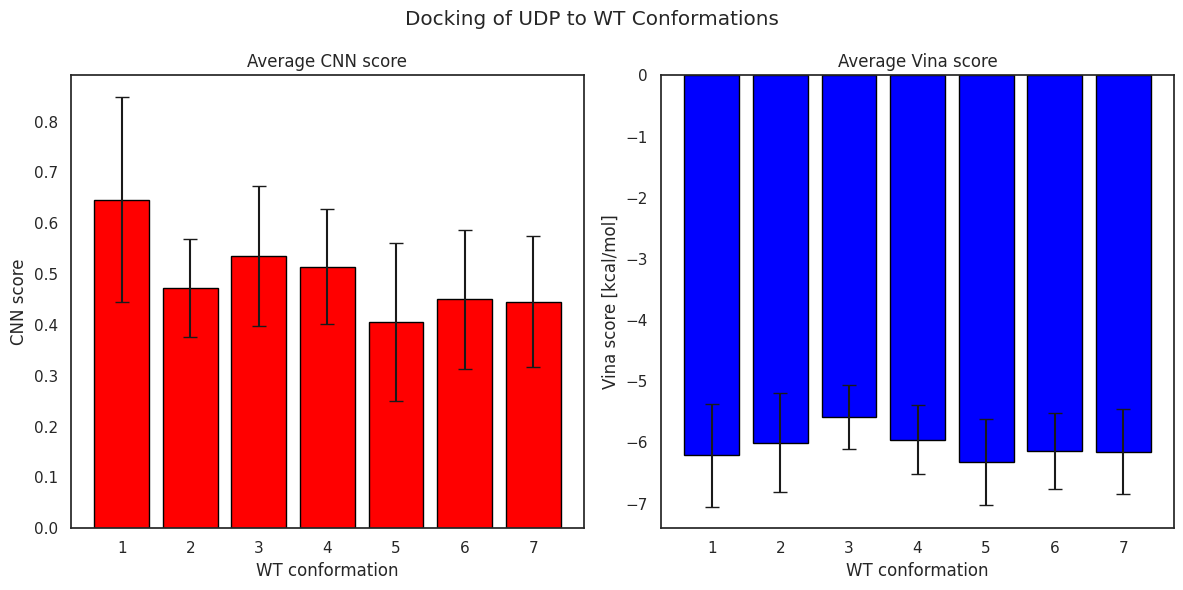

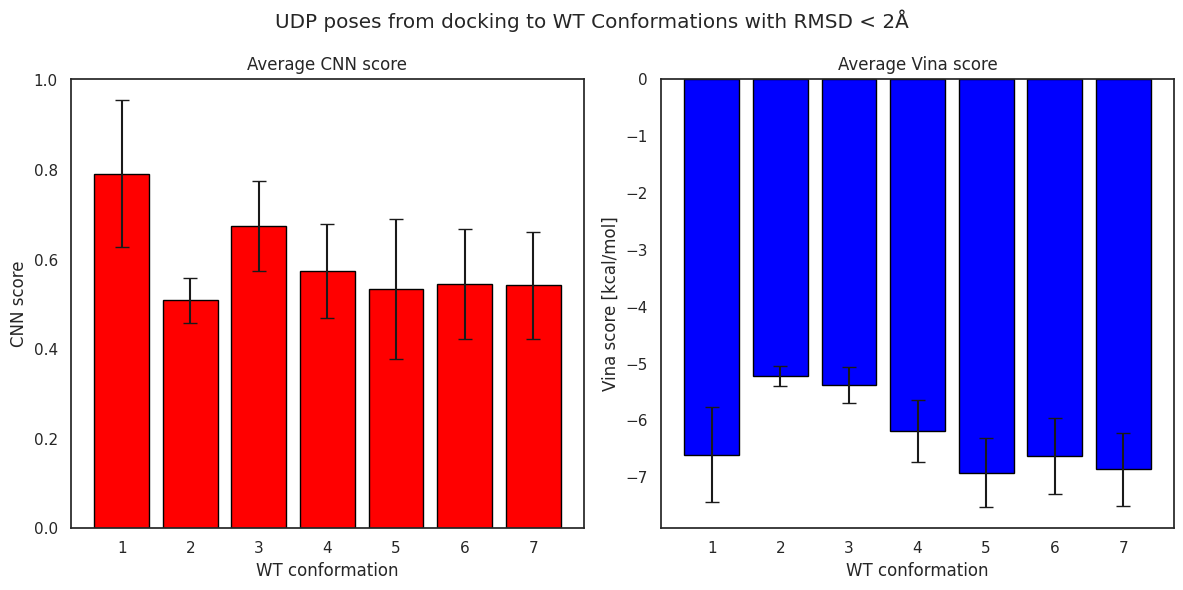

In [ ]:
# All poses before filtering:
average_cnn = []
std_cnn = []
average_vina = []
std_vina = []

for df in WT_udp:
  average_cnn.append(df['CNNscore'].mean())
  std_cnn.append(df['CNNscore'].std())
  average_vina.append(df['Vina'].mean())
  std_vina.append(df['Vina'].std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for CNN scores
ax1.bar(range(1, 8), average_cnn, yerr=std_cnn, capsize=5, color='red', edgecolor='black')
ax1.set_ylabel('CNN score')
ax1.set_xlabel('WT conformation')
ax1.set_title('Average CNN score')

# Plot for Vina scores
ax2.bar(range(1, 8), average_vina, yerr=std_vina, capsize=5, color='blue', edgecolor='black')
ax2.set_ylabel('Vina score [kcal/mol]')
ax2.set_xlabel('WT conformation')
ax2.set_title('Average Vina score')

fig.suptitle('Docking of UDP to WT Conformations')
plt.tight_layout()
plt.show()

# Filtered poses:
average_cnn = []
std_cnn = []
average_vina = []
std_vina = []

for df in WT_udp_filtered:
  average_cnn.append(df['CNNscore'].mean())
  std_cnn.append(df['CNNscore'].std())
  average_vina.append(df['Vina'].mean())
  std_vina.append(df['Vina'].std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for CNN scores
ax1.bar(range(1, 8), average_cnn, yerr=std_cnn, capsize=5, color='red', edgecolor='black')
ax1.set_ylabel('CNN score')
ax1.set_xlabel('WT conformation')
ax1.set_title('Average CNN score')

# Plot for Vina scores
ax2.bar(range(1, 8), average_vina, yerr=std_vina, capsize=5, color='blue', edgecolor='black')
ax2.set_ylabel('Vina score [kcal/mol]')
ax2.set_xlabel('WT conformation')
ax2.set_title('Average Vina score')

fig.suptitle('UDP poses from docking to WT Conformations with RMSD < 2Å')
plt.tight_layout()
plt.show()

## UDP-GlcA docked to WT

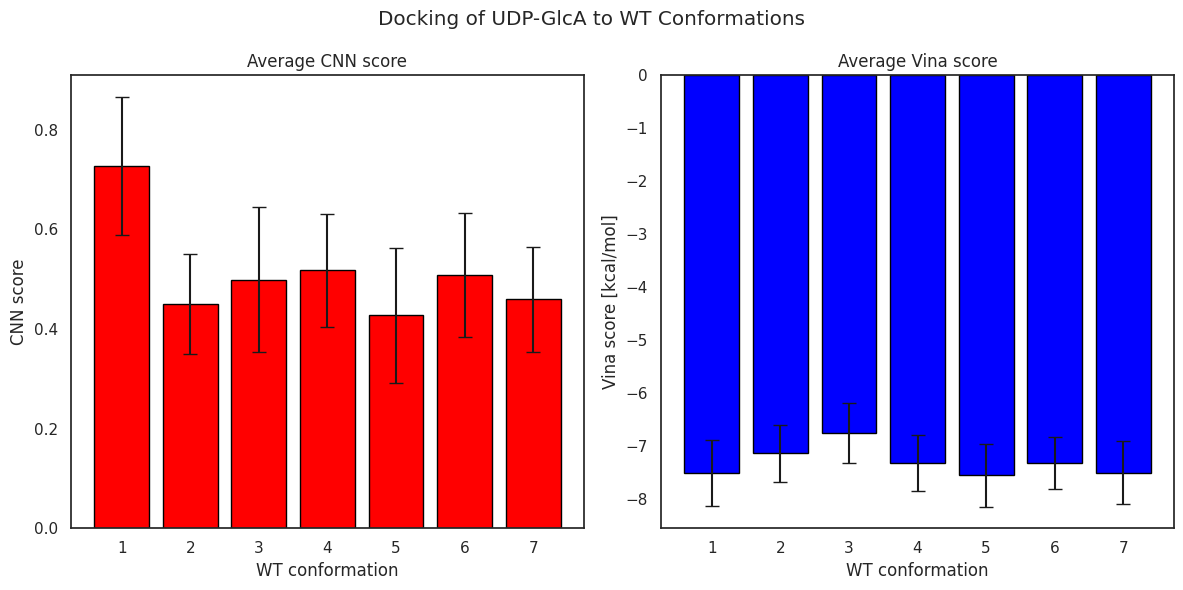

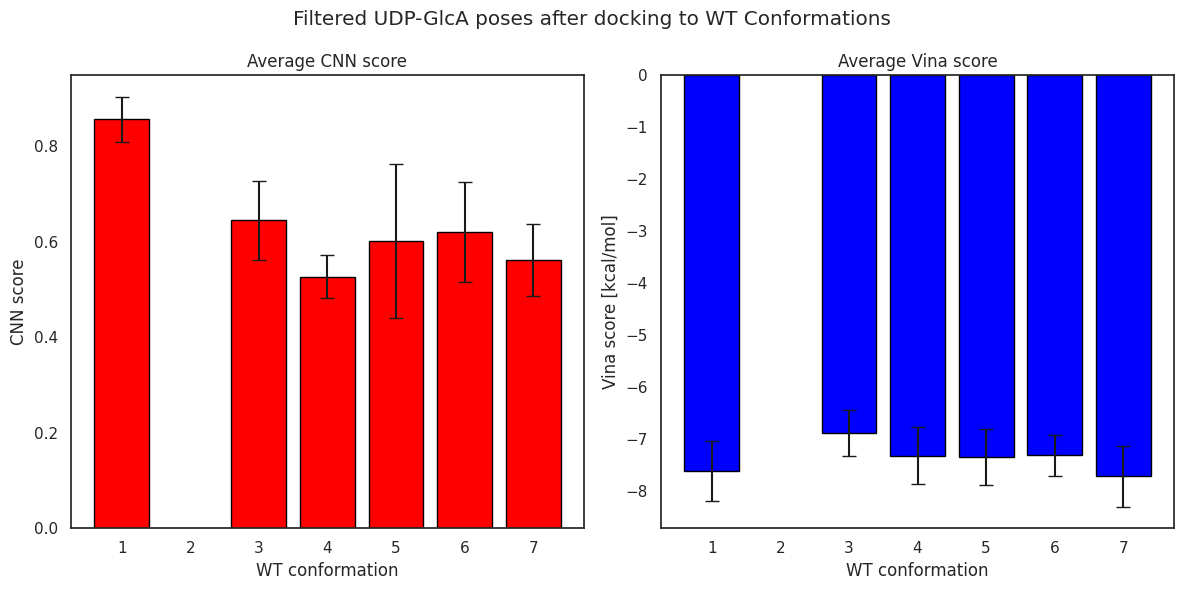

In [ ]:
# All poses before filtering:
average_cnn = []
std_cnn = []
average_vina = []
std_vina = []

for df in WT_glcA:
  average_cnn.append(df['CNNscore'].mean())
  std_cnn.append(df['CNNscore'].std())
  average_vina.append(df['Vina'].mean())
  std_vina.append(df['Vina'].std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for CNN scores
ax1.bar(range(1, 8), average_cnn, yerr=std_cnn, capsize=5, color='red', edgecolor='black')
ax1.set_ylabel('CNN score')
ax1.set_xlabel('WT conformation')
ax1.set_title('Average CNN score')

# Plot for Vina scores
ax2.bar(range(1, 8), average_vina, yerr=std_vina, capsize=5, color='blue', edgecolor='black')
ax2.set_ylabel('Vina score [kcal/mol]')
ax2.set_xlabel('WT conformation')
ax2.set_title('Average Vina score')

fig.suptitle('Docking of UDP-GlcA to WT Conformations')
plt.tight_layout()
plt.show()

# Filtered poses:
average_cnn = []
std_cnn = []
average_vina = []
std_vina = []

for df in WT_glcA_filtered:
  average_cnn.append(df['CNNscore'].mean())
  std_cnn.append(df['CNNscore'].std())
  average_vina.append(df['Vina'].mean())
  std_vina.append(df['Vina'].std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for CNN scores
ax1.bar(range(1, 8), average_cnn, yerr=std_cnn, capsize=5, color='red', edgecolor='black')
ax1.set_ylabel('CNN score')
ax1.set_xlabel('WT conformation')
ax1.set_title('Average CNN score')

# Plot for Vina scores
ax2.bar(range(1, 8), average_vina, yerr=std_vina, capsize=5, color='blue', edgecolor='black')
ax2.set_ylabel('Vina score [kcal/mol]')
ax2.set_xlabel('WT conformation')
ax2.set_title('Average Vina score')

fig.suptitle('Filtered UDP-GlcA poses after docking to WT Conformations')
plt.tight_layout()
plt.show()

## UDP-Glc docked to WT

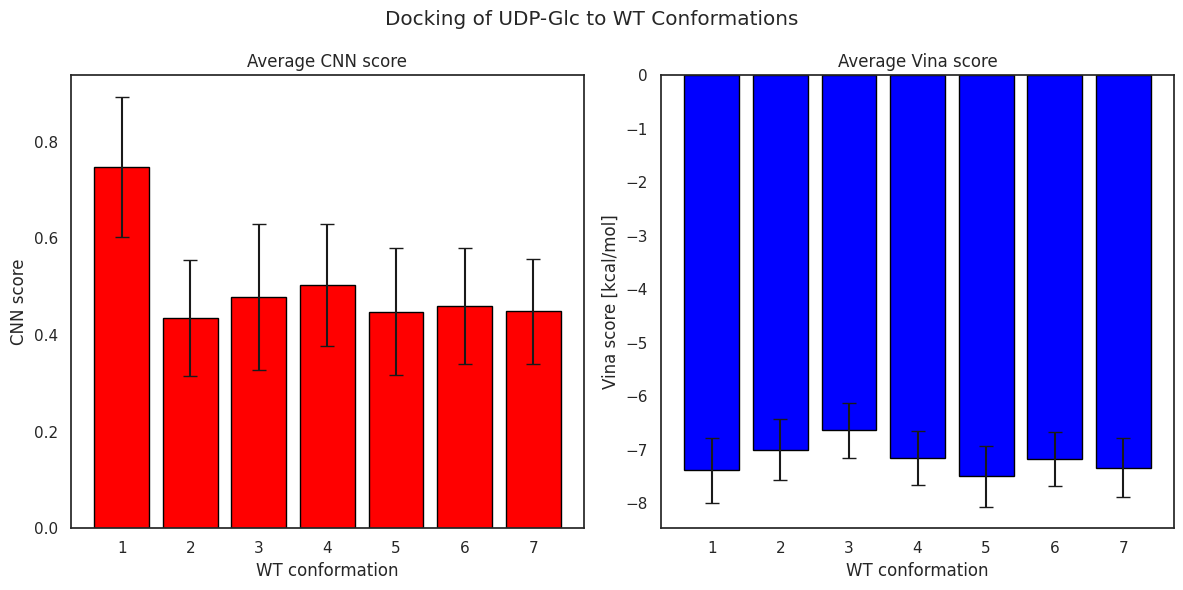

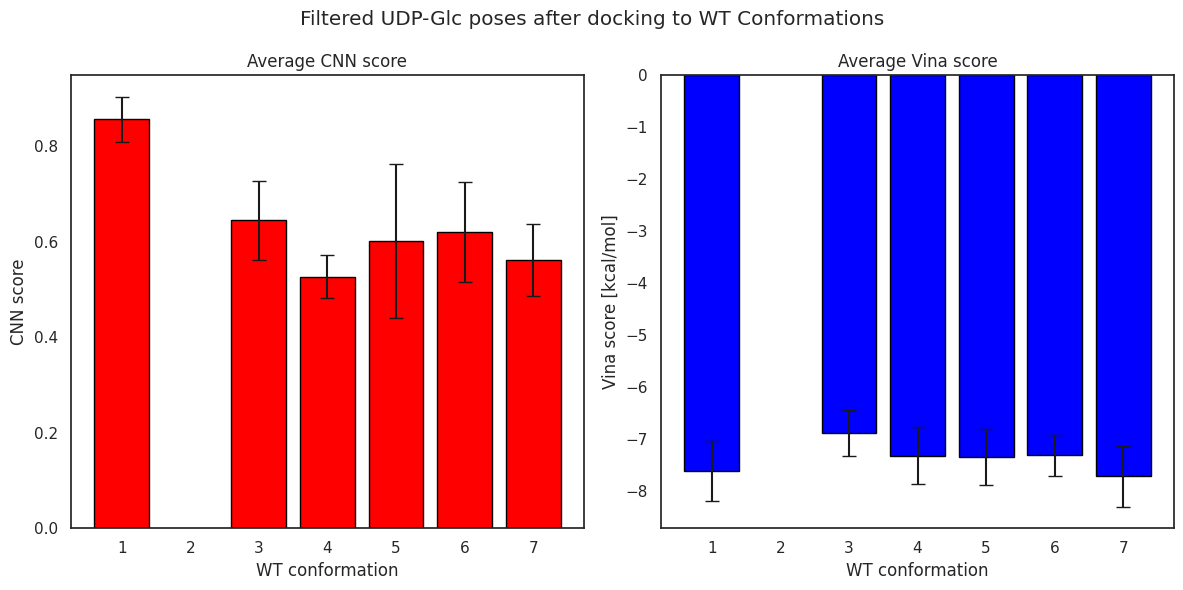

In [ ]:
# All poses before filtering:
average_cnn = []
std_cnn = []
average_vina = []
std_vina = []

for df in WT_glc:
  average_cnn.append(df['CNNscore'].mean())
  std_cnn.append(df['CNNscore'].std())
  average_vina.append(df['Vina'].mean())
  std_vina.append(df['Vina'].std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for CNN scores
ax1.bar(range(1, 8), average_cnn, yerr=std_cnn, capsize=5, color='red', edgecolor='black')
ax1.set_ylabel('CNN score')
ax1.set_xlabel('WT conformation')
ax1.set_title('Average CNN score')

# Plot for Vina scores
ax2.bar(range(1, 8), average_vina, yerr=std_vina, capsize=5, color='blue', edgecolor='black')
ax2.set_ylabel('Vina score [kcal/mol]')
ax2.set_xlabel('WT conformation')
ax2.set_title('Average Vina score')

fig.suptitle('Docking of UDP-Glc to WT Conformations')
plt.tight_layout()
plt.show()

# Filtered poses:
average_cnn = []
std_cnn = []
average_vina = []
std_vina = []

for df in WT_glc_filtered:
  average_cnn.append(df['CNNscore'].mean())
  std_cnn.append(df['CNNscore'].std())
  average_vina.append(df['Vina'].mean())
  std_vina.append(df['Vina'].std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for CNN scores
ax1.bar(range(1, 8), average_cnn, yerr=std_cnn, capsize=5, color='red', edgecolor='black')
ax1.set_ylabel('CNN score')
ax1.set_xlabel('WT conformation')
ax1.set_title('Average CNN score')

# Plot for Vina scores
ax2.bar(range(1, 8), average_vina, yerr=std_vina, capsize=5, color='blue', edgecolor='black')
ax2.set_ylabel('Vina score [kcal/mol]')
ax2.set_xlabel('WT conformation')
ax2.set_title('Average Vina score')

fig.suptitle('Filtered UDP-Glc poses after docking to WT Conformations')
plt.tight_layout()
plt.show()

## UDP-GlcA docked to mutants

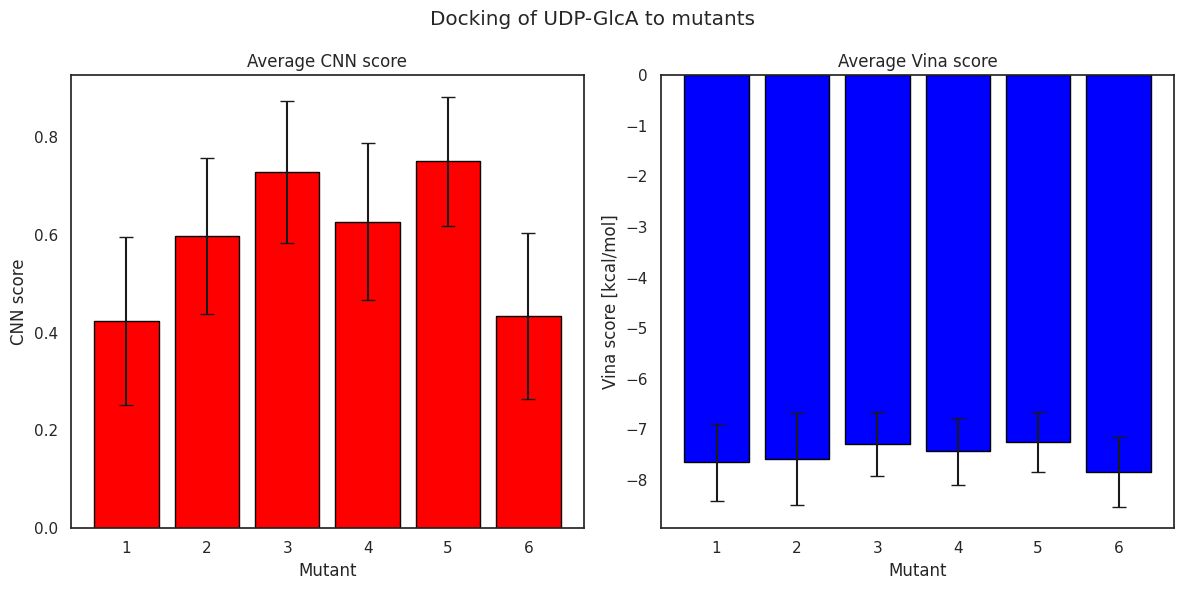

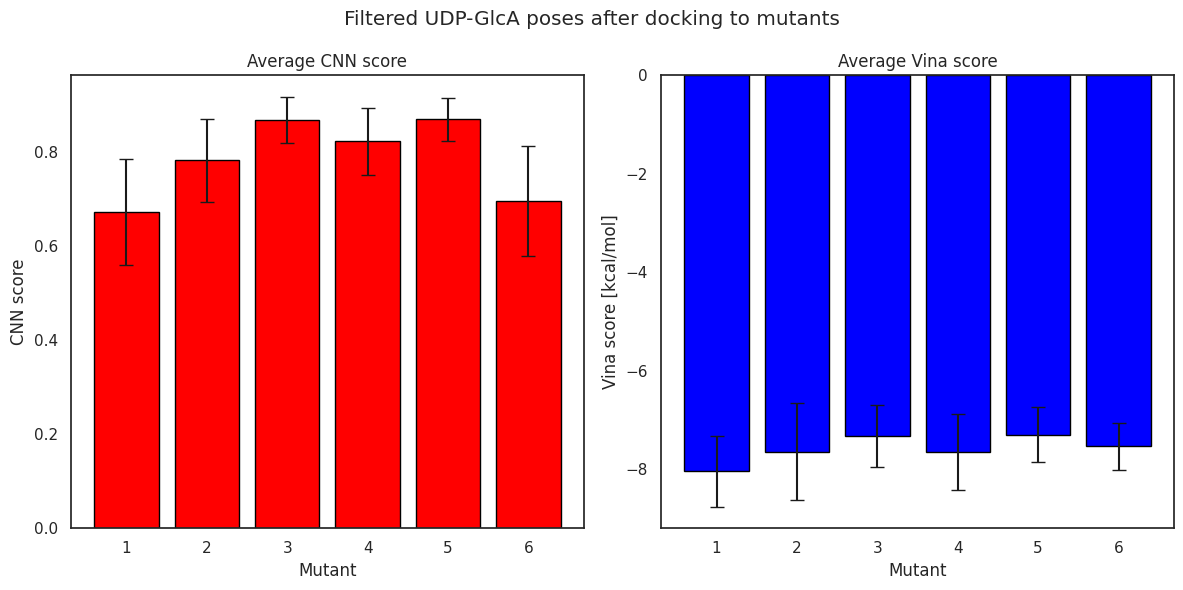

In [ ]:
# All poses before filtering:
average_cnn = []
std_cnn = []
average_vina = []
std_vina = []

for df in mut_glcA:
  average_cnn.append(df['CNNscore'].mean())
  std_cnn.append(df['CNNscore'].std())
  average_vina.append(df['Vina'].mean())
  std_vina.append(df['Vina'].std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for CNN scores
ax1.bar(range(1, 7), average_cnn, yerr=std_cnn, capsize=5, color='red', edgecolor='black')
ax1.set_ylabel('CNN score')
ax1.set_xlabel('Mutant')
ax1.set_title('Average CNN score')

# Plot for Vina scores
ax2.bar(range(1, 7), average_vina, yerr=std_vina, capsize=5, color='blue', edgecolor='black')
ax2.set_ylabel('Vina score [kcal/mol]')
ax2.set_xlabel('Mutant')
ax2.set_title('Average Vina score')

fig.suptitle('Docking of UDP-GlcA to mutants')
plt.tight_layout()
plt.show()

# Filtered poses:
average_cnn = []
std_cnn = []
average_vina = []
std_vina = []

for df in mut_glcA_filtered:
  average_cnn.append(df['CNNscore'].mean())
  std_cnn.append(df['CNNscore'].std())
  average_vina.append(df['Vina'].mean())
  std_vina.append(df['Vina'].std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for CNN scores
ax1.bar(range(1, 7), average_cnn, yerr=std_cnn, capsize=5, color='red', edgecolor='black')
ax1.set_ylabel('CNN score')
ax1.set_xlabel('Mutant')
ax1.set_title('Average CNN score')

# Plot for Vina scores
ax2.bar(range(1, 7), average_vina, yerr=std_vina, capsize=5, color='blue', edgecolor='black')
ax2.set_ylabel('Vina score [kcal/mol]')
ax2.set_xlabel('Mutant')
ax2.set_title('Average Vina score')

fig.suptitle('Filtered UDP-GlcA poses after docking to mutants')
plt.tight_layout()
plt.show()

## UDP-Glc docked to mutants

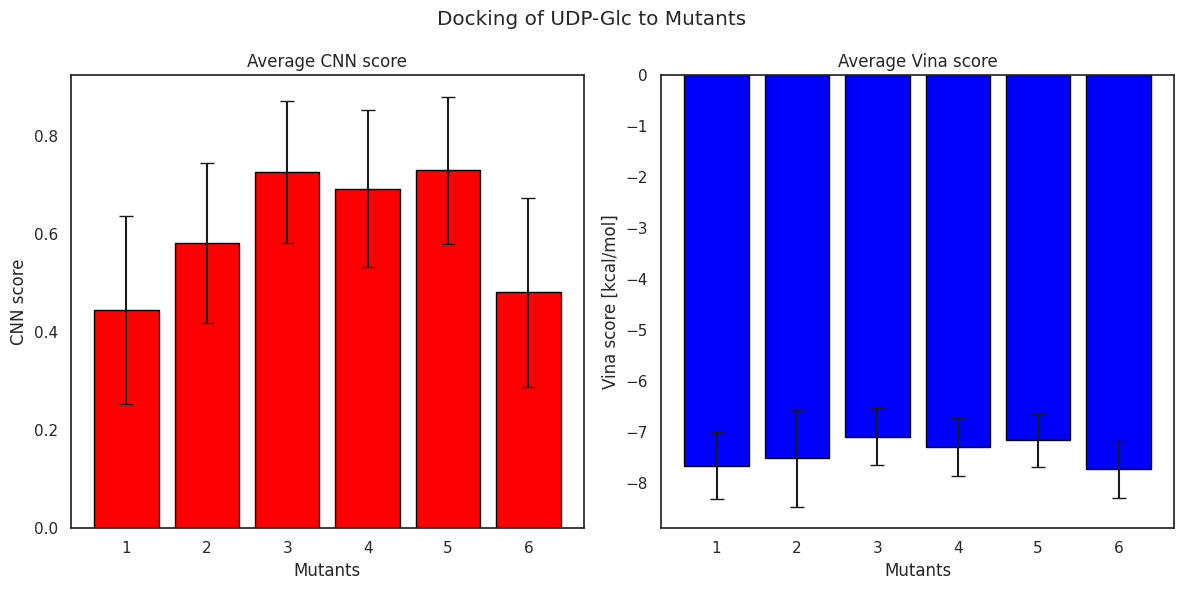

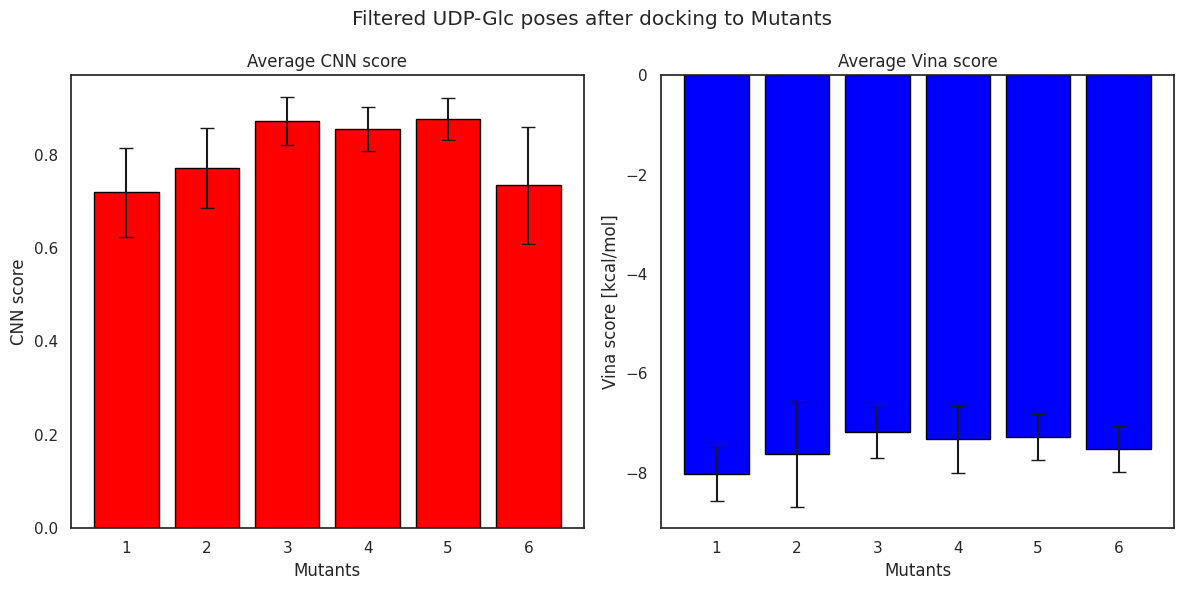

In [ ]:
# All poses before filtering:
average_cnn = []
std_cnn = []
average_vina = []
std_vina = []

for df in mut_glc:
  average_cnn.append(df['CNNscore'].mean())
  std_cnn.append(df['CNNscore'].std())
  average_vina.append(df['Vina'].mean())
  std_vina.append(df['Vina'].std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for CNN scores
ax1.bar(range(1, 7), average_cnn, yerr=std_cnn, capsize=5, color='red', edgecolor='black')
ax1.set_ylabel('CNN score')
ax1.set_xlabel('Mutants')
ax1.set_title('Average CNN score')

# Plot for Vina scores
ax2.bar(range(1, 7), average_vina, yerr=std_vina, capsize=5, color='blue', edgecolor='black')
ax2.set_ylabel('Vina score [kcal/mol]')
ax2.set_xlabel('Mutants')
ax2.set_title('Average Vina score')

fig.suptitle('Docking of UDP-Glc to Mutants')
plt.tight_layout()
plt.show()

# Filtered poses:
average_cnn = []
std_cnn = []
average_vina = []
std_vina = []

for df in mut_glc_filtered:
  average_cnn.append(df['CNNscore'].mean())
  std_cnn.append(df['CNNscore'].std())
  average_vina.append(df['Vina'].mean())
  std_vina.append(df['Vina'].std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for CNN scores
ax1.bar(range(1, 7), average_cnn, yerr=std_cnn, capsize=5, color='red', edgecolor='black')
ax1.set_ylabel('CNN score')
ax1.set_xlabel('Mutants')
ax1.set_title('Average CNN score')

# Plot for Vina scores
ax2.bar(range(1, 7), average_vina, yerr=std_vina, capsize=5, color='blue', edgecolor='black')
ax2.set_ylabel('Vina score [kcal/mol]')
ax2.set_xlabel('Mutants')
ax2.set_title('Average Vina score')

fig.suptitle('Filtered UDP-Glc poses after docking to Mutants')
plt.tight_layout()
plt.show()

# Analysis of poses from docking to WT conformation 1

The section contains the analysis of the poses obtained from docking of UDP-GlcA and UDP-Glc to the WT donor domain conformation 1

## Read in files

In [ ]:
score_file_path = 'WT1.xlsx'
sheet_name = 'UDP-GlcA'
docked_poses = 'WT1_glcA.sdf'

df_glcA = pd.read_excel(score_file_path, sheet_name=sheet_name)
supplier_glcA = Chem.SDMolSupplier(docked_poses)

score_file_path = 'WT1.xlsx'
sheet_name = 'UDP-Glc'
docked_poses = 'WT1_glc.sdf'

df_glc = pd.read_excel(score_file_path, sheet_name=sheet_name)
supplier_glc = Chem.SDMolSupplier(docked_poses)

protein = 'WT1.pdb'

## Filter poses

Filtering of the poses based on the median CNN score and the uridine RMSD compared to the crystal structure UDP.

In [ ]:
# Filtering of docked UDP-GlcA
print('UDP-GlcA:')
RMSD_min = 0
RMSD_max = 2
CNN_min = df_glcA['CNNscore'].median() # minimum CNN score = the median CNN score
CNN_max = 1

[filtered_poses_glcA, filtered_df_glcA] = filtering(supplier_glcA, df_glcA, ['RMSD', RMSD_min, RMSD_max], ['CNNscore', CNN_min, CNN_max])

# Filtering of docked UDP-Glc
print('UDP-Glc:')
RMSD_min = 0
RMSD_max = 2
CNN_min = df_glc['CNNscore'].median() # minimum CNN score = the median CNN score
CNN_max = 1

[filtered_poses_glc, filtered_df_glc] = filtering(supplier_glc, df_glc, ['RMSD', RMSD_min, RMSD_max], ['CNNscore', CNN_min, CNN_max])


UDP-GlcA:
number of filtered poses: 84, which is 42.0 % of the poses

UDP-Glc:
number of filtered poses: 90, which is 45.0 % of the poses



## Density maps of docking score vs C6-K307 distance

**CNN score vs distance**

Text(0.5, 1.0, 'CNN score vs distance - UDP-Glc docked to WT donor domain conformation 1')

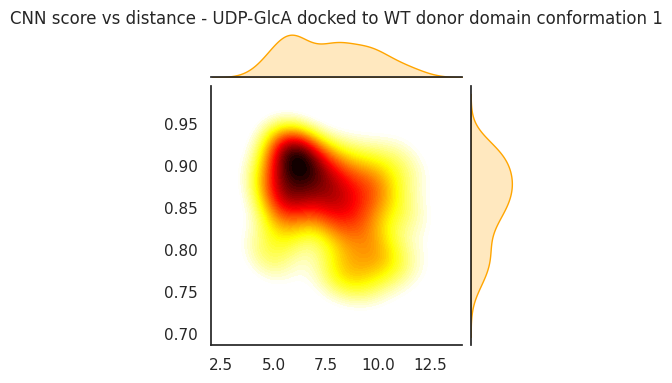

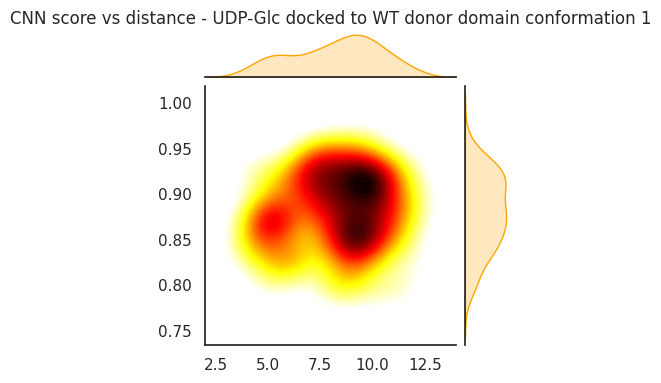

In [ ]:
sns.set(style="white")

f = sns.jointplot(x=filtered_df_glcA['distance'],
                  y=filtered_df_glcA['CNNscore'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  height=4,
                  xlim=(2, 14))
f.set_axis_labels("Distance [Å]", "CNN score")
f.ax_joint.set_title("CNN score vs distance - UDP-GlcA docked to WT donor domain conformation 1", pad=45)

f = sns.jointplot(x=filtered_df_glc['distance'],
                  y=filtered_df_glc['CNNscore'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  height=4,
                  xlim=(2, 14))
f.set_axis_labels("Distance [Å]", "CNN score")
f.ax_joint.set_title("CNN score vs distance - UDP-Glc docked to WT donor domain conformation 1", pad=45)

**Vina score vs distance**

Text(0.5, 1.0, 'Vina score vs distance - UDP-Glc docked to WT donor domain conformation 1')

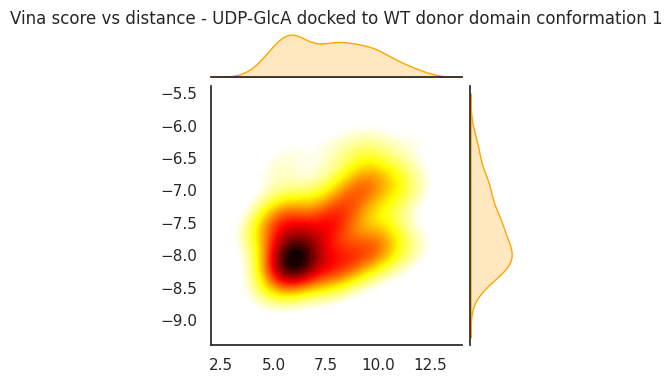

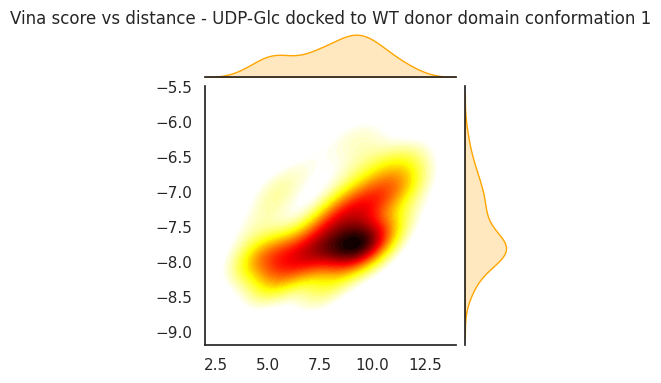

In [ ]:

f = sns.jointplot(x=filtered_df_glcA['distance'],
                  y=filtered_df_glcA['Vina'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  height=4,
                  xlim=(2, 14))
f.set_axis_labels("Distance [Å]", "Vina score [kcal/mol]")
f.ax_joint.set_title("Vina score vs distance - UDP-GlcA docked to WT donor domain conformation 1", pad=45)

f = sns.jointplot(x=filtered_df_glc['distance'],
                  y=filtered_df_glc['Vina'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  height=4,
                  xlim=(2, 14))
f.set_axis_labels("Distance [Å]", "Vina score [kcal/mol]")
f.ax_joint.set_title("Vina score vs distance - UDP-Glc docked to WT donor domain conformation 1", pad=45)



**CNN affinity score vs distance**

Text(0.5, 1.0, 'CNN affinity score vs distance - UDP-Glc docked to WT donor domain conformation 1')

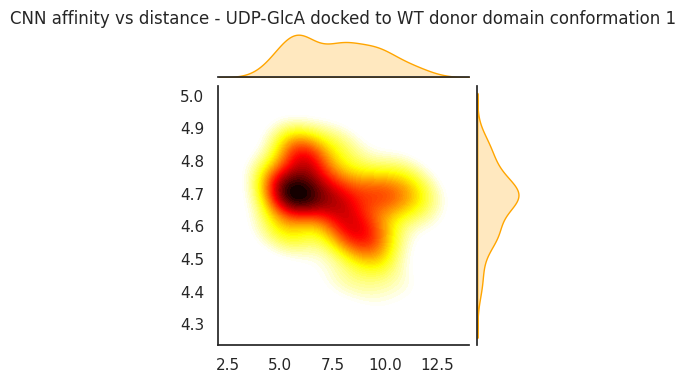

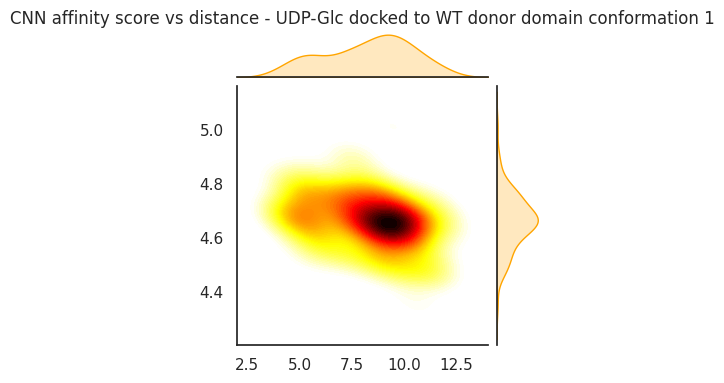

In [ ]:

f = sns.jointplot(x=filtered_df_glcA['distance'],
                  y=filtered_df_glcA['CNNaffinity'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  height=4,
                  xlim=(2, 14))
f.set_axis_labels("", "")
f.ax_joint.set_title("CNN affinity vs distance - UDP-GlcA docked to WT donor domain conformation 1", pad=45)

f = sns.jointplot(x=filtered_df_glc['distance'],
                  y=filtered_df_glc['CNNaffinity'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  height=4,
                  xlim=(2, 14))
f.set_axis_labels("", "")
f.ax_joint.set_title("CNN affinity score vs distance - UDP-Glc docked to WT donor domain conformation 1", pad=45)



**Vinardo score vs distance**

Text(0.5, 1.0, 'Vinardo score vs distance - UDP-Glc docked to WT donor domain conformation 1')

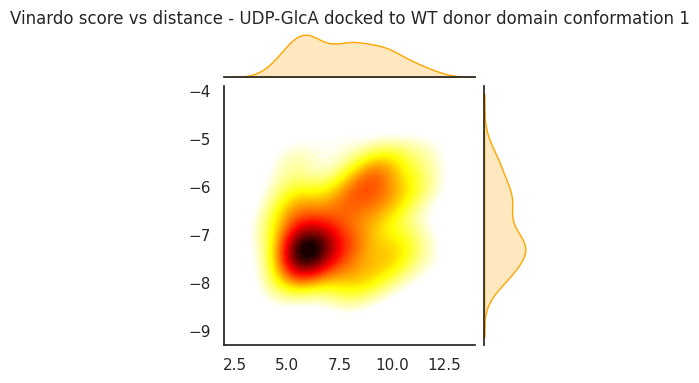

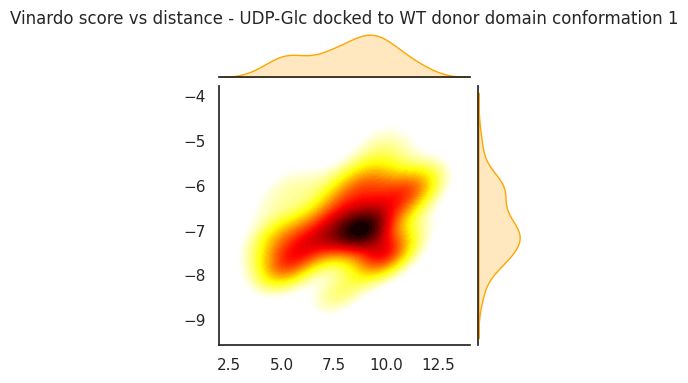

In [ ]:

f = sns.jointplot(x=filtered_df_glcA['distance'],
                  y=filtered_df_glcA['Vinardo'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  height=4,
                  xlim=(2, 14))
f.set_axis_labels("", "")
f.ax_joint.set_title("Vinardo score vs distance - UDP-GlcA docked to WT donor domain conformation 1", pad=45)

f = sns.jointplot(x=filtered_df_glc['distance'],
                  y=filtered_df_glc['Vinardo'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  height=4,
                  xlim=(2, 14))
f.set_axis_labels("", "")
f.ax_joint.set_title("Vinardo score vs distance - UDP-Glc docked to WT donor domain conformation 1", pad=45)



## Plot of dihedral angles

The follow cell plots the dihedral angles with the data points colored after the docked substrate. The poses are divided into two different plots, one for poses with a distance less than 7Å and one with a distance longer than 7Å.

Filtered UDP-GlcA poses with a distance < 7Å
number of filtered poses: 36, which is 42.86 % of the poses

Filtered UDP-Glc poses with a distance < 7Å
number of filtered poses: 24, which is 26.67 % of the poses



<Figure size 640x480 with 0 Axes>

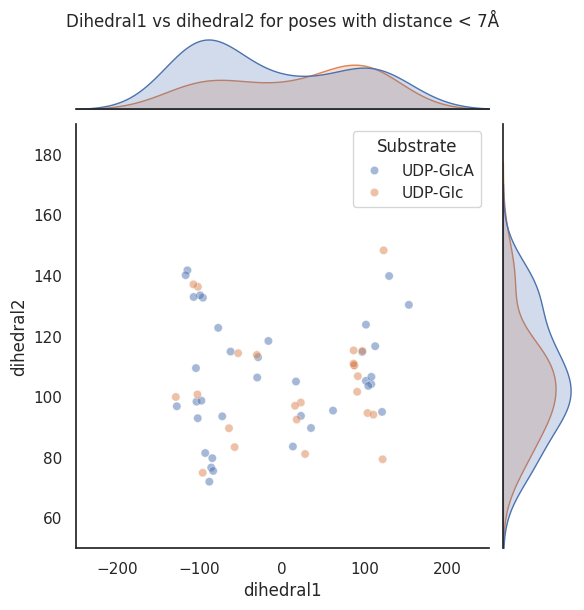

Filtered UDP-GlcA poses with a distance > 7Å
number of filtered poses: 48, which is 57.14 % of the poses

Filtered UDP-Glc poses with a distance > 7Å
number of filtered poses: 66, which is 73.33 % of the poses



<Figure size 640x480 with 0 Axes>

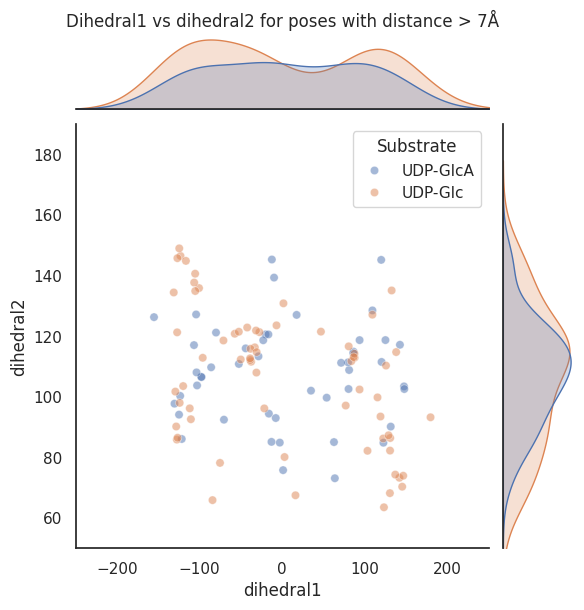

In [ ]:
print('Filtered UDP-GlcA poses with a distance < 7Å')
[temp_poses_glcA, temp_df_glcA] = filtering(filtered_poses_glcA, filtered_df_glcA, ['distance', 0,7])

print('Filtered UDP-Glc poses with a distance < 7Å')
[temp_poses_glc, temp_df_glc] = filtering(filtered_poses_glc, filtered_df_glc, ['distance', 0,7])

plt.tight_layout()
merged=pd.concat([temp_df_glcA, temp_df_glc])
f = sns.jointplot(data=merged, x="dihedral1", y="dihedral2", hue="Substrate", alpha=0.5, xlim = [-250,250], ylim=[50,190])
f.ax_joint.set_title("Dihedral1 vs dihedral2 for poses with distance < 7Å", pad=70)
plt.show()

print('Filtered UDP-GlcA poses with a distance > 7Å')
[temp_poses_glcA, temp_df_glcA] = filtering(filtered_poses_glcA, filtered_df_glcA, ['distance', 7,17],['Run', 0,10.5])
print('Filtered UDP-Glc poses with a distance > 7Å')
[temp_poses_glc, temp_df_glc] = filtering(filtered_poses_glc, filtered_df_glc, ['distance', 7,17],['Run', 0,10.5])

plt.tight_layout()
merged=pd.concat([temp_df_glcA, temp_df_glc])
f = sns.jointplot(data=merged, x="dihedral1", y="dihedral2", hue="Substrate", alpha=0.5, xlim = [-250,250], ylim=[50,190])
f.ax_joint.set_title("Dihedral1 vs dihedral2 for poses with distance > 7Å", pad=70)
plt.show()

## Heatmaps and clustering based on pairwise RMSD

In the following cells, the pairwise RMSD for all the filtered poses for each substrate is calculated and displayed as a heatmap (a graphical representation of the calculated values). Based on the calculated pairwise RMSD, the poses are clustered with hierarchical clustering (using the scipy kit). The linkage method used to calculate the distance between the clusters is 'average', and these distances are represented by a dendrogram. The clusters are formed by grouping all poses with a distance of maximum 7.  

More information about the clustering method used can be found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

### UDP-GlcA

**Displaying heatmap and corresponding dendrogram based on the pairwise RMSD**

<ipython-input-10-ecd1765ee220>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


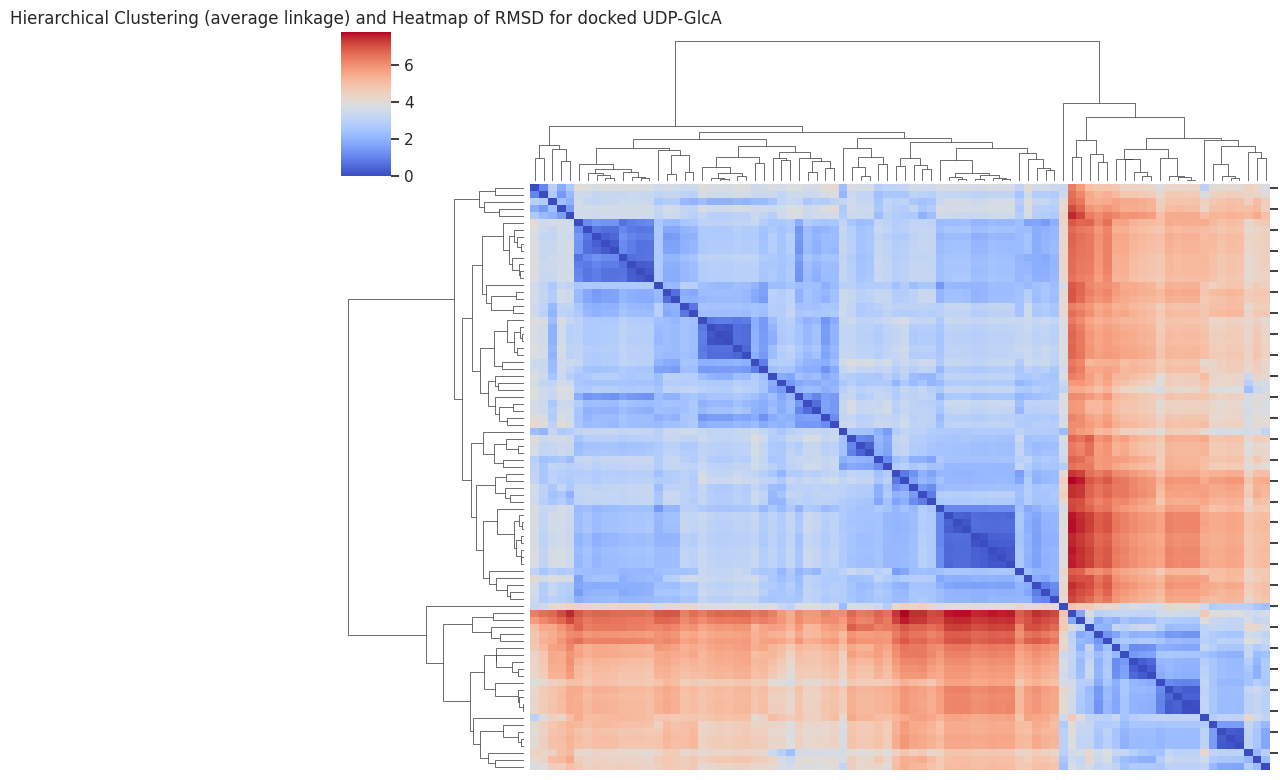

In [ ]:
filtered_file(filtered_poses_glcA, 'filtered_temp.sdf')

rmsd_matrix = RMSD_matrix(filtered_df_glcA.shape[0], 'filtered_temp.sdf')

os.remove('filtered_temp.sdf')

# Calculate linkage
linkage = hierarchy.linkage(rmsd_matrix, method='average')

# Plot the combined heatmap and dendrogram
cluster = sns.clustermap(rmsd_matrix, method='average', cmap='coolwarm', row_cluster=True, col_cluster=True, figsize=(10, 8) )

# Remove index labels on the axes
cluster.ax_heatmap.set_xticklabels([])
cluster.ax_heatmap.set_yticklabels([])

# Set title and labels
plt.title('Hierarchical Clustering (average linkage) and Heatmap of RMSD for docked UDP-GlcA')

# Show the plot
plt.show()

**Clustering of the poses based on the pairwise RMSD**

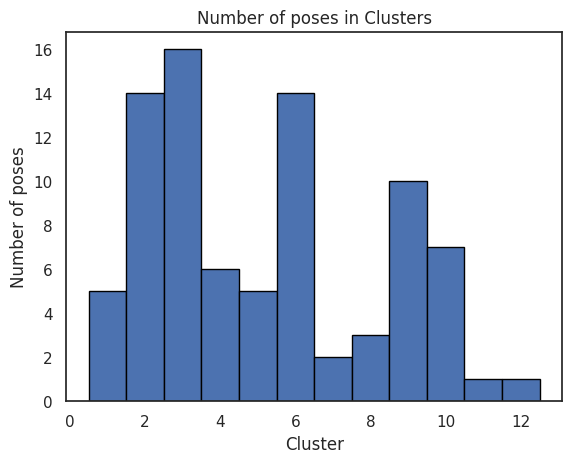

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 2.95997
Representative pose id: 89
CNN score of rep pose is 0.7720736265, distance is 10.87998851883586


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 2.9107
Representative pose id: 87
CNN score of rep pose is 0.8202062845, distance is 5.495565712463098


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 3.1123
Representative pose id: 141
CNN score of rep pose is 0.8977020383, distance is 6.205800647781076


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 2.5178
Representative pose id: 166
CNN score of rep pose is 0.8482387066, distance is 7.551045181959918


-----------  cluster 5 ------------------------
Largest RMSD between two poses: 2.13153
Representative pose id: 88
CNN score of rep pose is 0.7849254012, distance is 10.04240315561968


-----------  cluster 6 ------------------------
Largest RMSD between tw

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
threshold = 7 # threshold for maximum distance when clustering
df = filtered_df_glcA.copy() # the dataframe with the scores for the poses that will be clustered
poses_list = filtered_poses_glcA # the corresponding poses that should be clustered

clusters = fcluster(linkage, threshold, criterion='distance')

nbr_clusters = len(set(clusters))

# Plot histogram
plt.hist(clusters, bins=range(1, nbr_clusters+2), align='left', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Number of poses')
plt.title('Number of poses in each cluster')
plt.show()

df.insert(1, "cluster", clusters, True)

counter = Counter(clusters)
max_poses = max(counter.values()) # number of poses in largest cluster(s)

# Get largest cluster(s)
largest_cluster = [k for k, v in counter.items() if v == max_poses]


rep_pose = [] # representative pose for largest cluster(s)

for c in range(1,nbr_clusters+1):
  nbr_c = clusters == c
  nbr_c = np.sum(nbr_c)

  if nbr_c > 1:
    poses = []
    pose_id = df[df['cluster'] == c]
    for p in poses_list:
      if int(p.GetProp('_Name')) in pose_id['id'].values:
        poses.append(p)
    filtered_file(poses, 'temp_poses.sdf')

    [rep_pose_mol, rmsd_matrix, rmsd_df] = representative_pose(poses, 'temp_poses.sdf')
    os.remove('temp_poses.sdf')

    print(f'-----------  cluster {c} ------------------------')
    print(f'Largest RMSD between two poses: {rmsd_matrix.max()}')

    mol_name = rep_pose_mol.GetProp('_Name')
    score_rep_pose = df[df['id'] == int(mol_name)]
    print(f'Representative pose id: {mol_name}')

    s = score_rep_pose['CNNscore'].values[0]
    d = score_rep_pose['distance'].values[0]
    print(f'CNN score of rep pose is {s}, distance is {d}')
    print('')
    print('')
  else:
    pose_id = df[df['cluster'] == c]
    pose_id = pose_id['id']
    print(f'-----------  cluster {c} ------------------------')
    print(f'Representative pose id: {pose_id.values[0]}')
    print('Note! Only one pose in the cluster')
    print('')
    print('')

  if c in largest_cluster:
    rep_pose.append(rep_pose_mol)

print('representative pose(s) for largest cluster(s):')
for mol in rep_pose:
  display(protein, mol)

### UDP-Glc

**Heatmap and corresponding dendrogram based on the pairwise RMSD**

<ipython-input-12-d94bc202f966>:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


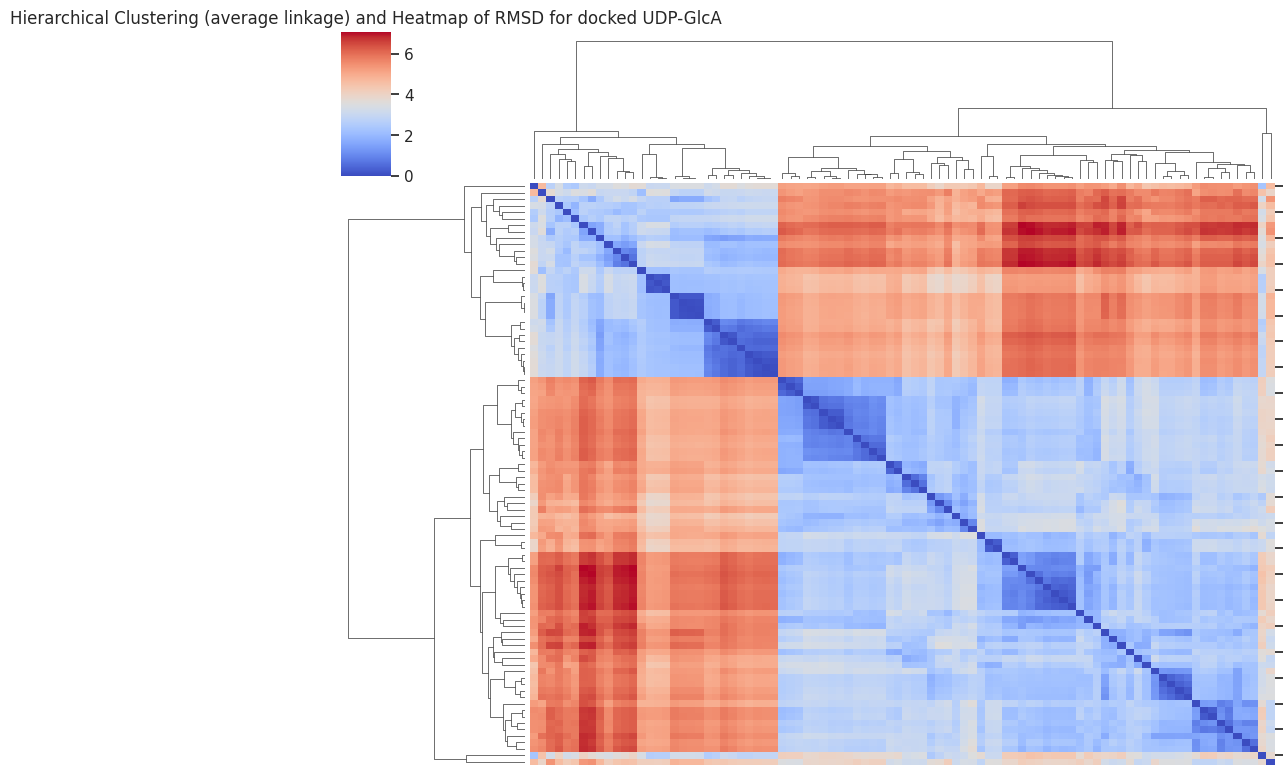

In [ ]:
filtered_file(filtered_poses_glc, 'filtered_temp.sdf')

rmsd_matrix = RMSD_matrix(filtered_df_glc.shape[0], 'filtered_temp.sdf')

os.remove('filtered_temp.sdf')

# Calculate linkage
linkage = hierarchy.linkage(rmsd_matrix, method='average')

# Plot the combined heatmap and dendrogram
cluster = sns.clustermap(rmsd_matrix, method='average', cmap='coolwarm', row_cluster=True, col_cluster=True, figsize=(10, 8))

# Remove index labels on the axes
cluster.ax_heatmap.set_xticklabels([])
cluster.ax_heatmap.set_yticklabels([])

# Set title and labels
plt.title('Hierarchical Clustering (average linkage) and Heatmap of RMSD for docked UDP-GlcA')

# Show the plot
plt.show()

**Clustering of the poses based on the pairwise RMSD**

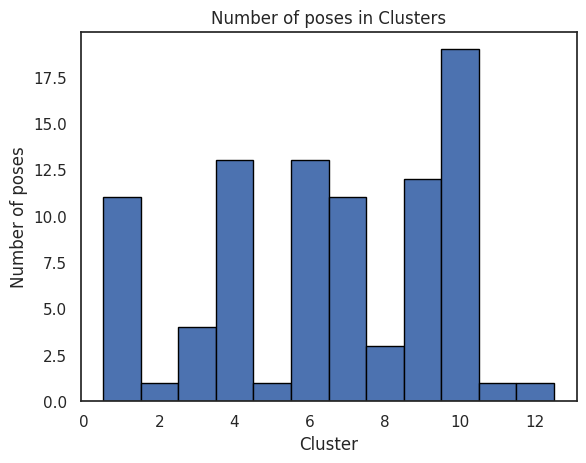

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.3272
Representative pose id: 144
CNN score of rep pose is 0.8848305345, distance is 11.40483100093991


-----------  cluster 2 ------------------------
Representative pose id: 47
Note! Only one pose in the cluster


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 2.21022
Representative pose id: 183
CNN score of rep pose is 0.8886398673, distance is 7.741784929846603


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 2.22378
Representative pose id: 2
CNN score of rep pose is 0.9181028605, distance is 10.01784699523805


-----------  cluster 5 ------------------------
Representative pose id: 161
Note! Only one pose in the cluster


-----------  cluster 6 ------------------------
Largest RMSD between two poses: 2.0292
Representative pose id: 106
CNN score of rep pose is 0.8755292296, distance is 5.227997962891727


-----------  cluster 7 --------

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
threshold = 7
df = filtered_df_glc.copy() # the dataframe with the scores for the poses that will be clustered
poses_list = filtered_poses_glc # the corresponding poses that should be clustered

clusters = fcluster(linkage, threshold, criterion='distance')

nbr_clusters = len(set(clusters))

# Plot histogram
plt.hist(clusters, bins=range(1, nbr_clusters+2), align='left', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Number of poses')
plt.title('Number of poses in each cluster')
plt.show()

df.insert(1, "cluster", clusters, True)

counter = Counter(clusters)
max_poses = max(counter.values()) # number of poses in largest cluster(s)

# Get largest cluster(s)
largest_cluster = [k for k, v in counter.items() if v == max_poses]


rep_pose = [] # representative pose for largest cluster(s)

for c in range(1,nbr_clusters+1):
  nbr_c = clusters == c
  nbr_c = np.sum(nbr_c)

  if nbr_c > 1:
    poses = []
    pose_id = df[df['cluster'] == c]
    for p in poses_list:
      if int(p.GetProp('_Name')) in pose_id['id'].values:
        poses.append(p)
    filtered_file(poses, 'temp_poses.sdf')

    [rep_pose_mol, rmsd_matrix, rmsd_df] = representative_pose(poses, 'temp_poses.sdf')
    os.remove('temp_poses.sdf')

    print(f'-----------  cluster {c} ------------------------')
    print(f'Largest RMSD between two poses: {rmsd_matrix.max()}')

    mol_name = rep_pose_mol.GetProp('_Name')
    score_rep_pose = df[df['id'] == int(mol_name)]
    print(f'Representative pose id: {mol_name}')

    s = score_rep_pose['CNNscore'].values[0]
    d = score_rep_pose['distance'].values[0]
    print(f'CNN score of rep pose is {s}, distance is {d}')
    print('')
    print('')
  else:
    pose_id = df[df['cluster'] == c]
    pose_id = pose_id['id']
    print(f'-----------  cluster {c} ------------------------')
    print(f'Representative pose id: {pose_id.values[0]}')
    print('Note! Only one pose in the cluster')
    print('')
    print('')

  if c in largest_cluster:
    rep_pose.append(rep_pose_mol)

print('representative pose(s) for largest cluster(s):')
for mol in rep_pose:
  display(protein, mol)

# Analysis of poses from docking to WT conformation 2-7

## Read in files

In [ ]:
proteins = ['WT2.pdb', 'WT3.pdb','WT4.pdb','WT5.pdb','WT6.pdb', 'WT7.pdb']
udp_files = ['WT2_udp.sdf', 'WT3_udp.sdf','WT4_udp.sdf','WT5_udp.sdf','WT6_udp.sdf', 'WT7_udp.sdf']
glcA_files = ['WT2_glcA.sdf', 'WT3_glcA.sdf','WT4_glcA.sdf','WT5_glcA.sdf','WT6_glcA.sdf', 'WT7_glcA.sdf']
glc_files = ['WT2_glc.sdf', 'WT3_glc.sdf','WT4_glc.sdf','WT5_glc.sdf','WT6_glc.sdf', 'WT7_glc.sdf']
score_files = ['WT2.xlsx', 'WT3.xlsx','WT4.xlsx','WT5.xlsx','WT6.xlsx', 'WT7.xlsx']

df_udp = []
df_glcA = []
df_glc = []
udp = []
glcA = []
glc = []

for score_file, l1, l2, l3 in zip(score_files, udp_files, glcA_files, glc_files):
  sheet_name = 'UDP'
  df_udp.append(pd.read_excel(score_file, sheet_name=sheet_name))
  sheet_name = 'UDP-GlcA'
  df_glcA.append(pd.read_excel(score_file, sheet_name=sheet_name))
  sheet_name = 'UDP-Glc'
  df_glc.append(pd.read_excel(score_file, sheet_name=sheet_name))
  udp.append(Chem.SDMolSupplier(l1))
  glcA.append(Chem.SDMolSupplier(l2))
  glc.append(Chem.SDMolSupplier(l3))

## Filter poses

Filtering of the poses the poses based on the CNN score and the uridine RMSD. The UDP-GlcA and UDP-Glc poses are filtered based on both the score and the RMSD, whereas the UDP is only filtered based on the RMSD.  

In [ ]:
filtered_udp = []
filtered_glcA = []
filtered_glc = []
filtered_df_udp = []
filtered_df_glcA = []
filtered_df_glc = []

RMSD_min = 0
RMSD_max = 2
CNN_max = 1

conformation = 2

# go through the files for all conformations to get the filtered poses
for l1, l2, l3, l1_df, l2_df, l3_df in zip(udp, glcA, glc, df_udp, df_glcA, df_glc):
  print(f'conformation {conformation}:')
  # filter UDP (only on RMSD)
  print('UDP (filtered only on RMSD): ')
  [filtered_poses, filtered_df] = filtering(l1, l1_df, ['RMSD', RMSD_min, RMSD_max])
  filtered_udp.append(filtered_poses)
  filtered_df_udp.append(filtered_df)

  # filter UDP-GlcA (based on both RMSD and CNN score)
  print('UDP-GlcA: ')
  CNN_min = l2_df['CNNscore'].median() # minimum CNN score = the median CNN score
  [filtered_poses, filtered_df] = filtering(l2, l2_df, ['RMSD', RMSD_min, RMSD_max], ['CNNscore', CNN_min, CNN_max])
  filtered_df_glcA.append(filtered_df)
  filtered_glcA.append(filtered_poses)

  # filter UDP-Glc (based on both RMSD and CNN score)
  print('UDP-Glc: ')
  CNN_min = l3_df['CNNscore'].median() # minimum CNN score = the median CNN score
  [filtered_poses, filtered_df] = filtering(l3, l3_df, ['RMSD', RMSD_min, RMSD_max], ['CNNscore', CNN_min, CNN_max])
  filtered_df_glc.append(filtered_df)
  filtered_glc.append(filtered_poses)

  print('----------------------------------------------------------------------\n')
  conformation = conformation + 1

conformation 2:
UDP (filtered only on RMSD): 
number of filtered poses: 5, which is 2.5 % of the poses

UDP-GlcA: 
number of filtered poses: 0, which is 0.0 % of the poses

UDP-Glc: 
number of filtered poses: 0, which is 0.0 % of the poses

----------------------------------------------------------------------

conformation 3:
UDP (filtered only on RMSD): 
number of filtered poses: 23, which is 11.5 % of the poses

UDP-GlcA: 
number of filtered poses: 19, which is 9.5 % of the poses

UDP-Glc: 
number of filtered poses: 14, which is 7.0 % of the poses

----------------------------------------------------------------------

conformation 4:
UDP (filtered only on RMSD): 
number of filtered poses: 26, which is 13.0 % of the poses

UDP-GlcA: 
number of filtered poses: 3, which is 1.5 % of the poses

UDP-Glc: 
number of filtered poses: 5, which is 2.5 % of the poses

----------------------------------------------------------------------

conformation 5:
UDP (filtered only on RMSD): 
number of

## Density plots of distance vs docking score

The following cells give the density plots of the distance vs CNN score and  distance vs Vina score for the filtered UDP-Glc and UDP-GlcA from docking to the different protein conformations.

**CNN score vs distance**

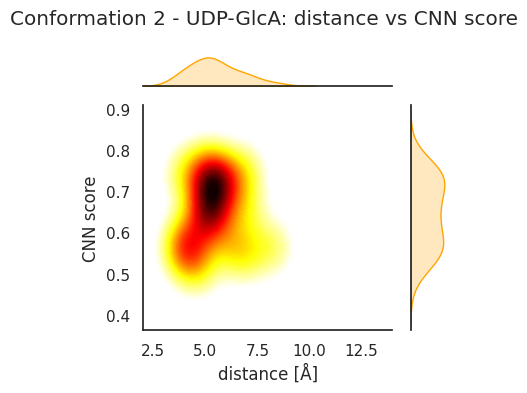

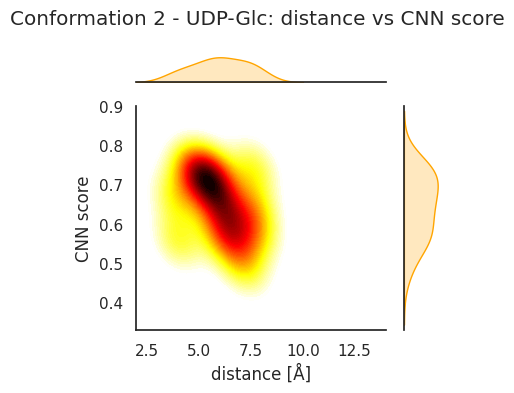

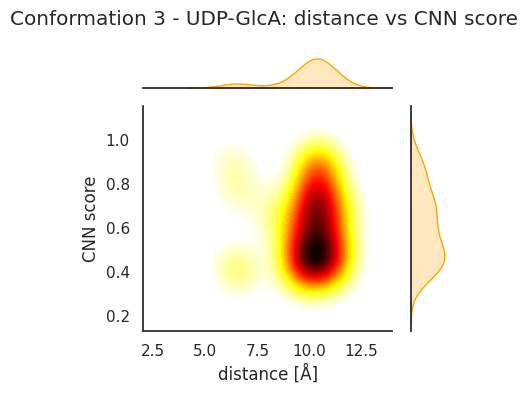

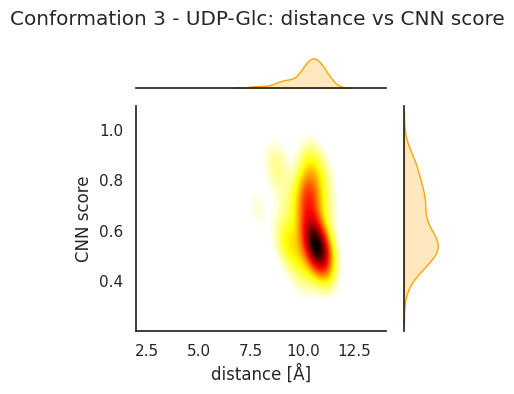

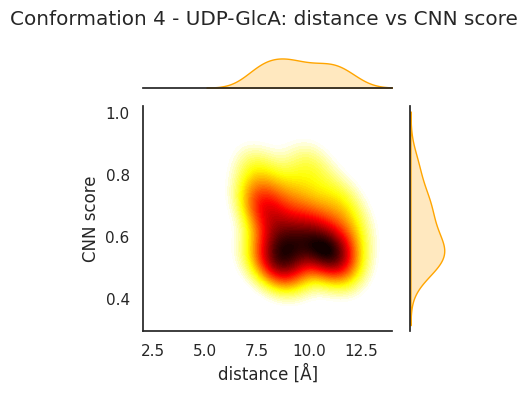

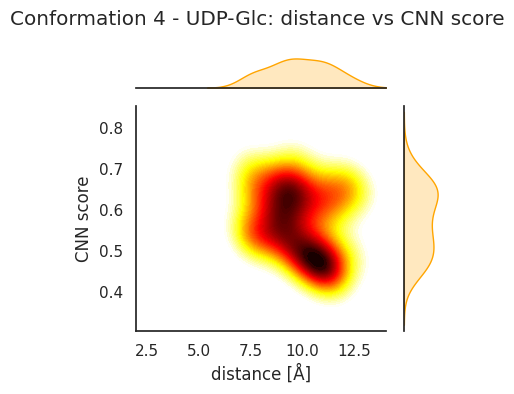

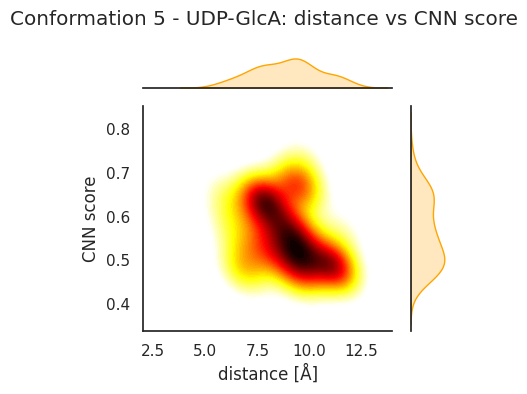

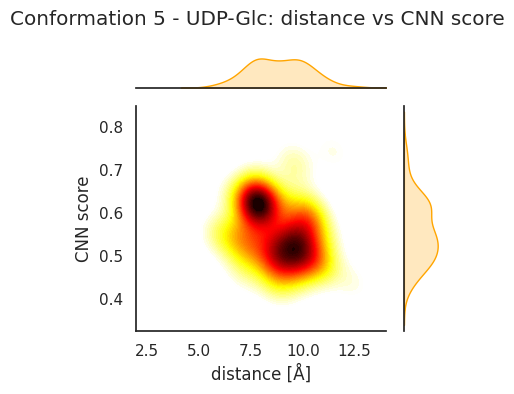

In [ ]:
conformation = 2

# goes through all the filtered UDP-GlcA and UDP-Glc poses from docking to the different WT conformations
for l1, l2 in zip(filtered_df_glcA, filtered_df_glc):
  # check if the number of filtered poses is more than 5
  if len(l1) > 5:
    sns.set(style="white")

    f = sns.jointplot(x=l1['distance'],
                      y=l1['CNNscore'],
                      kind='kde',
                      cmap='hot_r',
                      n_levels=60,
                      fill=True,
                      marginal_kws=dict(color="orange"),
                      xlim=(2, 14),
                      height=4)
    f.set_axis_labels("distance [Å]", "CNN score")
    f.fig.suptitle(f'Conformation {conformation} - UDP-GlcA: distance vs CNN score')
    plt.tight_layout()
    plt.show()

    if len(l2) > 5:
      sns.set(style="white")

      f = sns.jointplot(x=l2['distance'],
                        y=l2['CNNscore'],
                        kind='kde',
                        cmap='hot_r',
                        n_levels=60,
                        fill=True,
                        marginal_kws=dict(color="orange"),
                        xlim=(2, 14),
                        height=4)
      f.set_axis_labels("distance [Å]", "CNN score")
      f.fig.suptitle(f'Conformation {conformation} - UDP-Glc: distance vs CNN score')
      plt.tight_layout()
      plt.show()

    conformation = conformation + 1



**Distance vs Vina score**

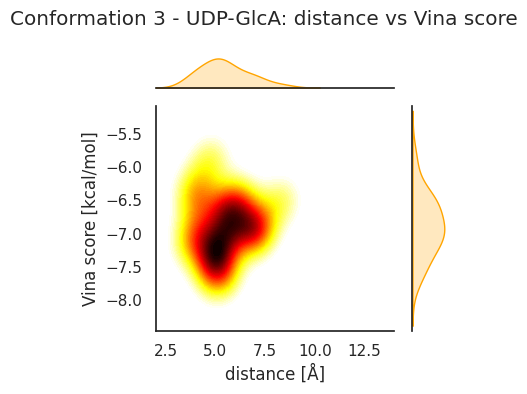

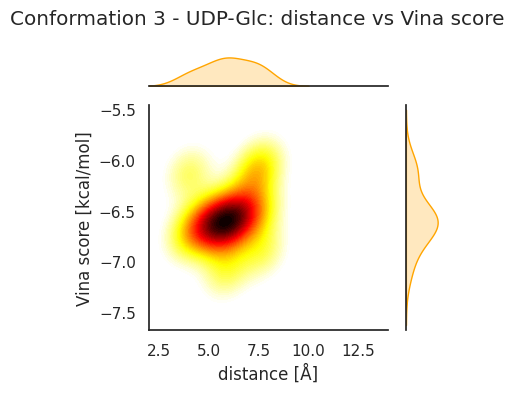

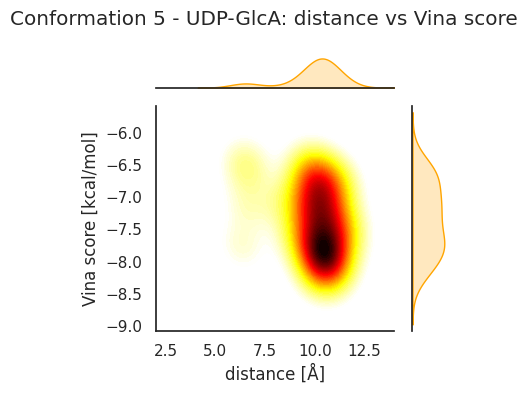

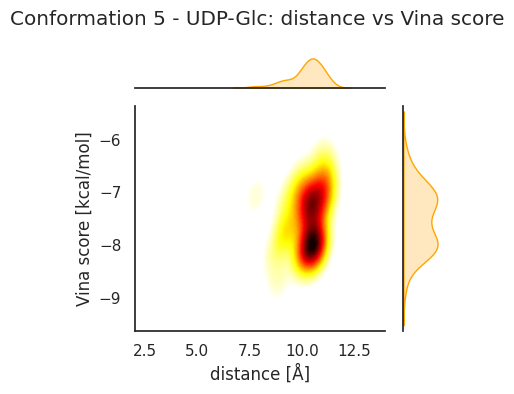

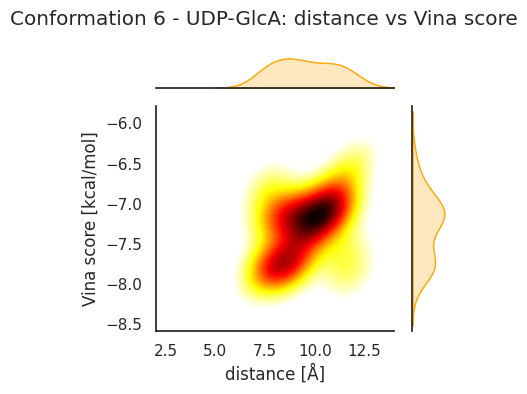

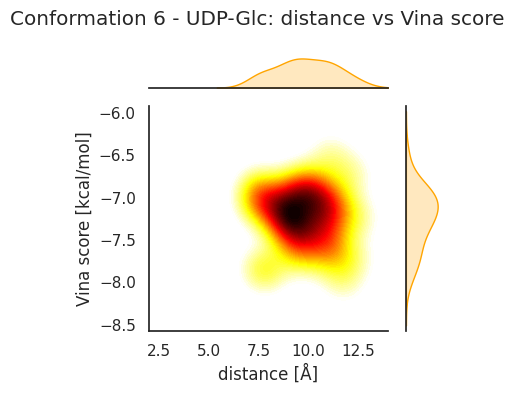

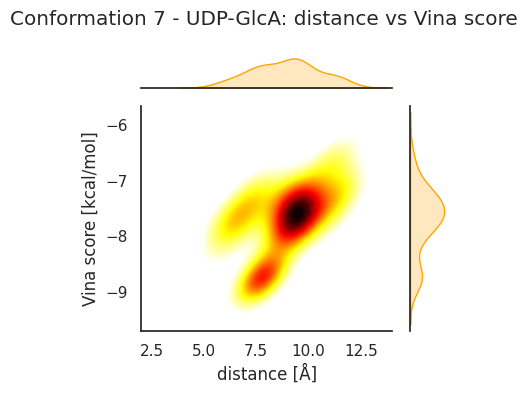

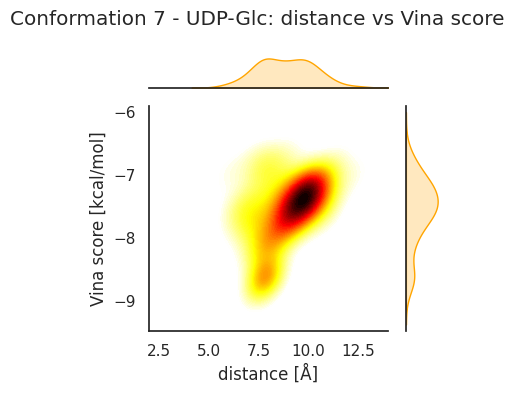

In [ ]:
conformation = 2

# goes through all the filtered UDP-GlcA and UDP-Glc poses from docking to the different WT conformations
for l1, l2 in zip(filtered_df_glcA, filtered_df_glc):
  # check if the number of filtered poses is more than 5
  if len(l1) > 5:
    sns.set(style="white")

    f = sns.jointplot(x=l1['distance'],
                      y=l1['Vina'],
                      kind='kde',
                      cmap='hot_r',
                      n_levels=60,
                      fill=True,
                      marginal_kws=dict(color="orange"),
                      xlim=(2, 14),
                      height=4)
    f.set_axis_labels("distance [Å]", "Vina score [kcal/mol]")
    f.fig.suptitle(f'Conformation {conformation} - UDP-GlcA: distance vs Vina score')
    plt.tight_layout()
    plt.show()

  if len(l2) > 5:
      sns.set(style="white")

      f = sns.jointplot(x=l2['distance'],
                        y=l2['Vina'],
                        kind='kde',
                        cmap='hot_r',
                        n_levels=60,
                        fill=True,
                        marginal_kws=dict(color="orange"),
                        xlim=(2, 14),
                        height=4)
      f.set_axis_labels("distance [Å]", "Vina score [kcal/mol]")
      f.fig.suptitle(f'Conformation {conformation} - UDP-Glc: distance vs Vina score')
      plt.tight_layout()
      plt.show()

  conformation = conformation + 1


## Plot of dihedral angles

The follow cell plots the dihedral angles for the UDP-GlcA and UDP-Glc poses from docking to the different wild type conformations.

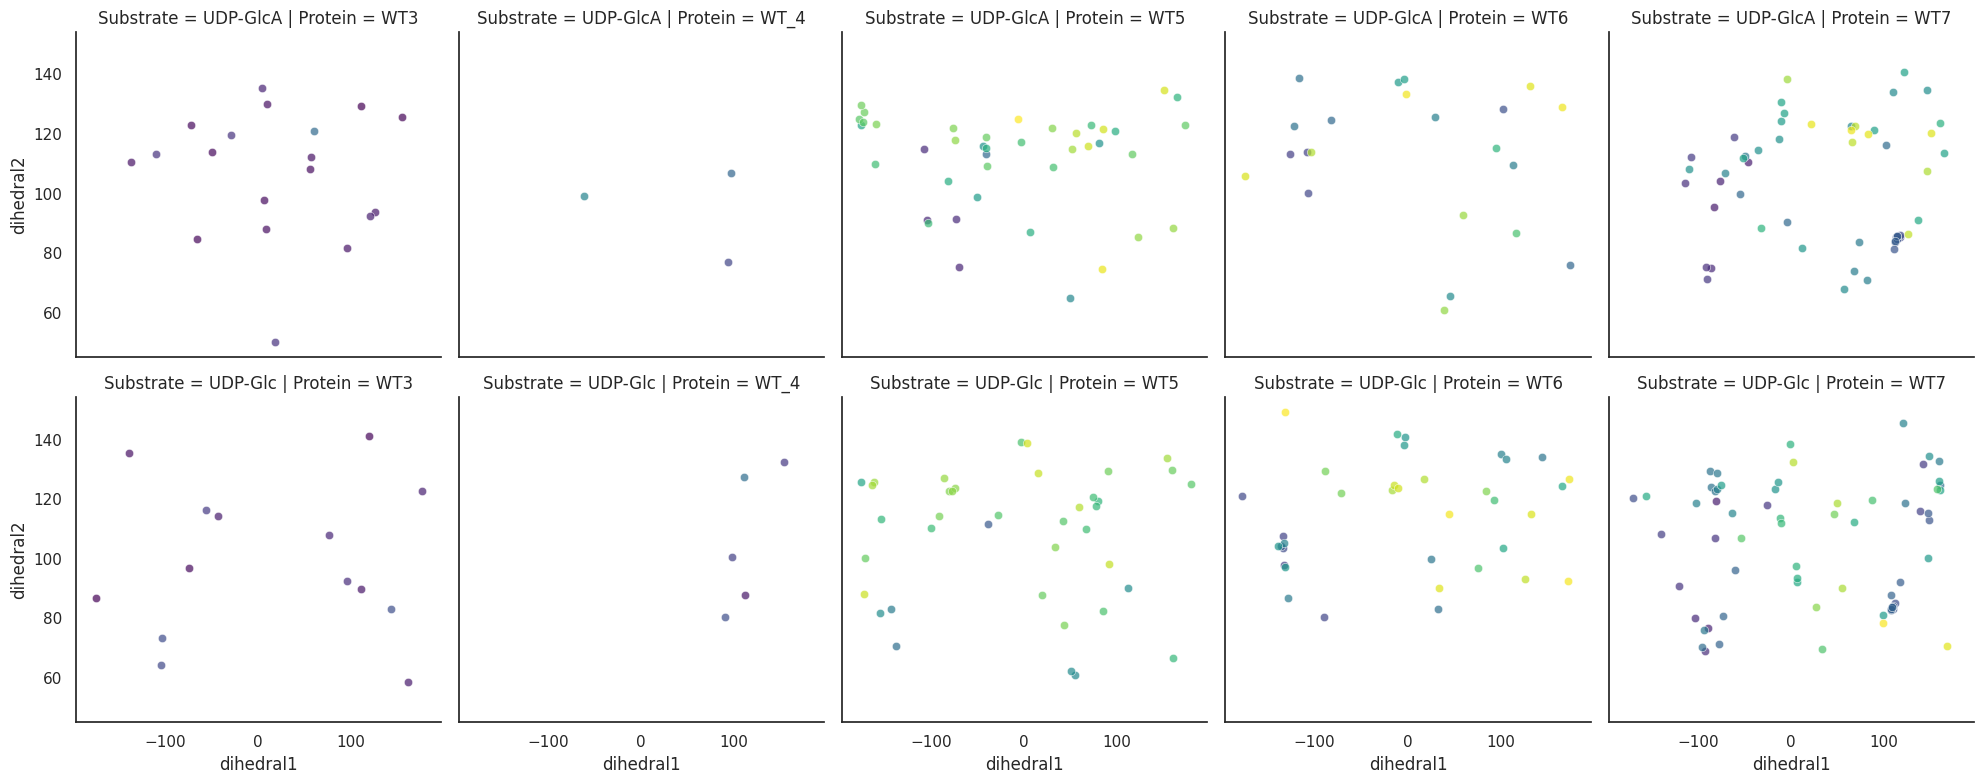

In [ ]:
merged = pd.DataFrame()

for l1, l2 in zip(filtered_df_glcA, filtered_df_glc):
  merged = pd.concat((merged, l1), axis=0)
  merged = pd.concat((merged, l2), axis=0)
g = sns.FacetGrid(merged, col="Protein",row='Substrate', hue="distance", palette='viridis',  height=4)
g.map(sns.scatterplot, "dihedral1", "dihedral2", alpha=.7)


## Heatmaps and clustering based on pairwise RMSD

In the following cells, the pairwise RMSD for all the filtered poses for each substrate is calculated and displayed as a heatmap (a graphical representation of the calculated values). Based on the calculated pairwise RMSD, the poses are clustered with hierarchical clustering (using the scipy kit). The linkage method used to calculate the distance between the clusters is 'average', and these distances are represented by a dendrogram. The clusters are formed by grouping all poses with a distance of maximum 7.

More information about the clustering method used can be found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html




### UDP-GlcA

**Displaying the heatmap and dendrogram**




<ipython-input-86-1313663a081a>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


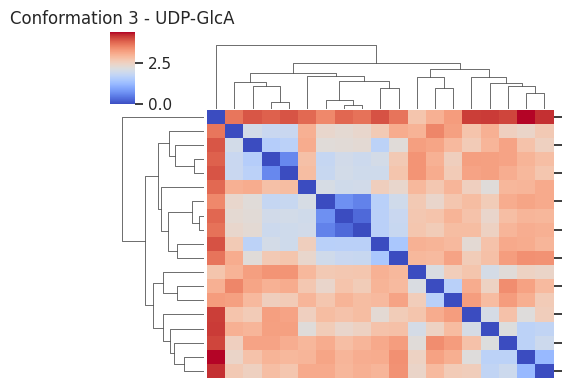

<ipython-input-86-1313663a081a>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


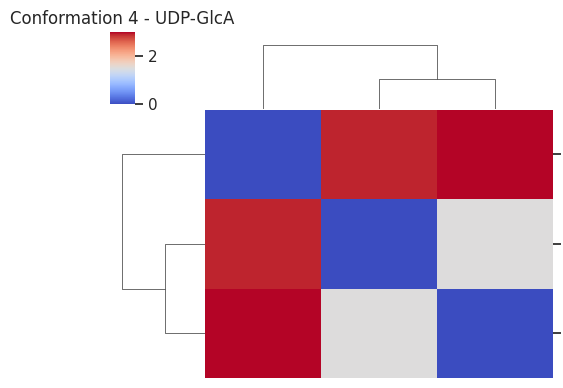

<ipython-input-86-1313663a081a>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


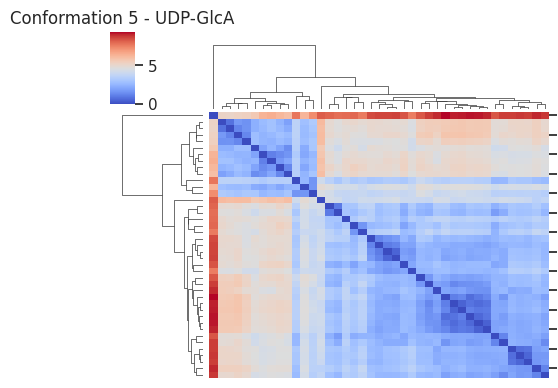

<ipython-input-86-1313663a081a>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


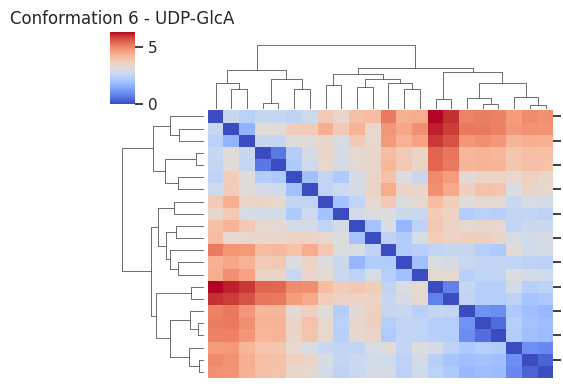

<ipython-input-86-1313663a081a>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


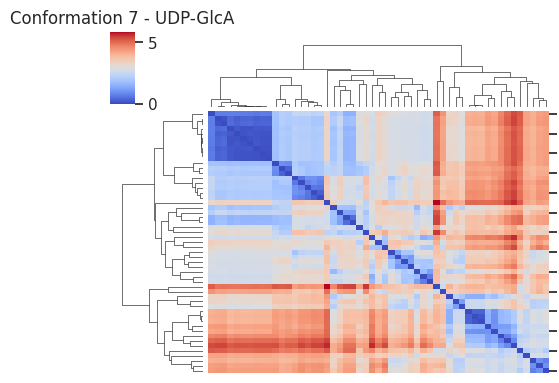

In [ ]:
conformation = 2
for poses, df in zip(filtered_glcA, filtered_df_glcA):
  if df.shape[0] > 0:
    filtered_file(poses, 'filtered_temp.sdf')

    rmsd_matrix = RMSD_matrix(df.shape[0], 'filtered_temp.sdf')

    os.remove('filtered_temp.sdf')

    # Calculate linkage
    linkage = hierarchy.linkage(rmsd_matrix, method='average')

    # Plot the combined heatmap and dendrogram
    cluster = sns.clustermap(rmsd_matrix, method='average', cmap='coolwarm', row_cluster=True, col_cluster=True, figsize=(5, 4))

    # Remove index labels on the axes
    cluster.ax_heatmap.set_xticklabels([])
    cluster.ax_heatmap.set_yticklabels([])

    # Set title and labels
    plt.title(f'Conformation {conformation} - UDP-GlcA')

    # Show the plot
    plt.show()
  conformation = conformation + 1

**Clustering of the UDP-GlcA poses**

<ipython-input-90-46437d625a9f>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


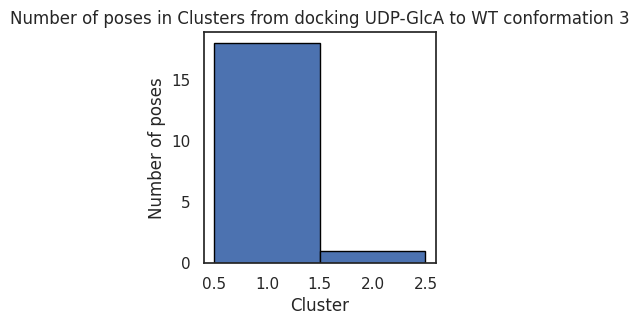

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.48736
Representative pose id: 63
CNN score of rep pose is 0.7370226383, distance is 5.326465614269934


-----------  cluster 2 ------------------------
Representative pose id: 107
Note! Only one pose in the cluster




<ipython-input-90-46437d625a9f>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


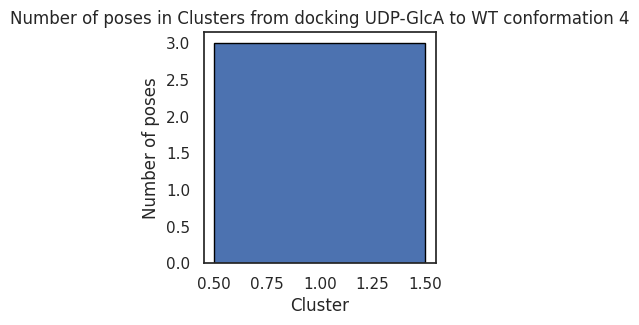

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 2.97288
Representative pose id: 6
CNN score of rep pose is 0.4863794446, distance is 7.546606312111421




<ipython-input-90-46437d625a9f>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


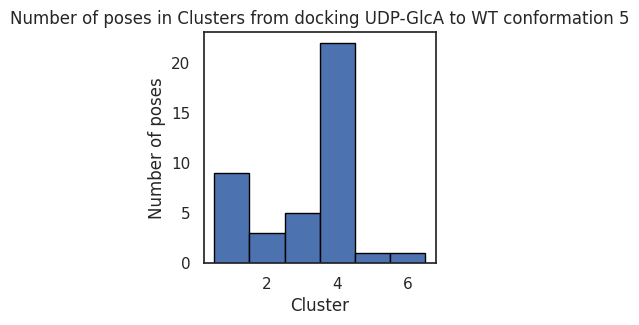

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 2.91063
Representative pose id: 83
CNN score of rep pose is 0.5288731456, distance is 11.2820346055133


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 2.56161
Representative pose id: 181
CNN score of rep pose is 0.8941707015, distance is 6.322154950647758


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 3.65726
Representative pose id: 90
CNN score of rep pose is 0.3910554945, distance is 9.681321898377309


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 3.5737
Representative pose id: 102
CNN score of rep pose is 0.8041693568, distance is 10.49673458366934


-----------  cluster 5 ------------------------
Representative pose id: 108
Note! Only one pose in the cluster


-----------  cluster 6 ------------------------
Representative pose id: 164
Note! Only one pose in the cluster




<ipython-input-90-46437d625a9f>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


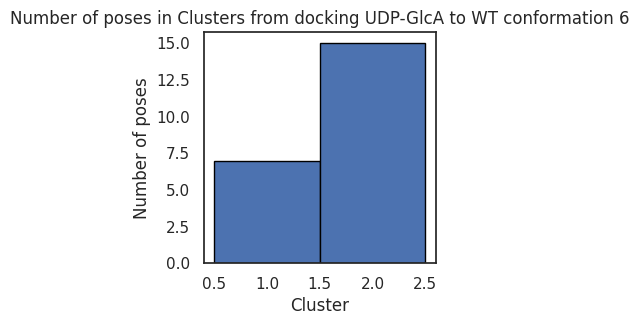

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.74459
Representative pose id: 122
CNN score of rep pose is 0.7308912873, distance is 7.443294659624857


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 4.10043
Representative pose id: 128
CNN score of rep pose is 0.4846653342, distance is 8.646812334612104




<ipython-input-90-46437d625a9f>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


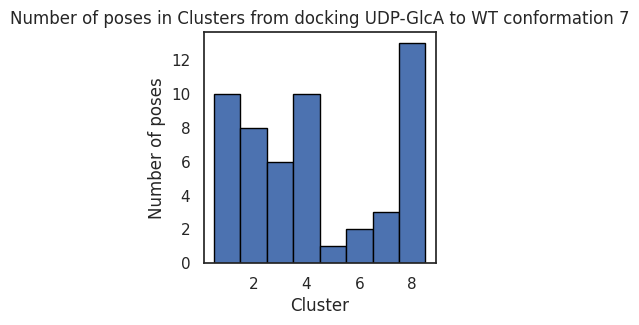

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 0.704194
Representative pose id: 42
CNN score of rep pose is 0.6329410076, distance is 7.804581738312432


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 2.18421
Representative pose id: 51
CNN score of rep pose is 0.4909148812, distance is 6.50788821738664


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 2.70486
Representative pose id: 65
CNN score of rep pose is 0.5733346343, distance is 8.930378720972588


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 3.72967
Representative pose id: 183
CNN score of rep pose is 0.5859235525, distance is 8.776554814390437


-----------  cluster 5 ------------------------
Representative pose id: 173
Note! Only one pose in the cluster


-----------  cluster 6 ------------------------
Largest RMSD between two poses: 2.59103
Representative pose id: 146
CNN score of rep pose is 0

In [ ]:
threshold = 7 # threshold for maximum distance when clustering
conformation = 2

for poses, df in zip(filtered_glcA, filtered_df_glcA):
  if df.shape[0] > 0:
    filtered_file(poses, 'filtered_temp.sdf')

    rmsd_matrix = RMSD_matrix(df.shape[0], 'filtered_temp.sdf')

    os.remove('filtered_temp.sdf')

    # Calculate linkage
    linkage = hierarchy.linkage(rmsd_matrix, method='average')

    df_temp = df.copy() # the dataframe with the scores for the poses that will be clustered
    poses_list = poses # the corresponding poses that should be clustered

    clusters = fcluster(linkage, threshold, criterion='distance')

    nbr_clusters = len(set(clusters))

    # Plot histogram
    plt.figure(figsize=(3, 3))
    plt.hist(clusters, bins=range(1, nbr_clusters+2), align='left', edgecolor='black')
    plt.xlabel('Cluster')
    plt.ylabel('Number of poses')
    plt.title(f'Number of poses in Clusters from docking UDP-GlcA to WT conformation {conformation}')
    plt.show()

    df_temp.insert(1, "cluster", clusters, True)

    for c in range(1,nbr_clusters+1):
      nbr_c = clusters == c
      nbr_c = np.sum(nbr_c)

      if nbr_c > 1:
        poses = []
        pose_id = df_temp[df_temp['cluster'] == c]
        for p in poses_list:
          if int(p.GetProp('_Name')) in pose_id['id'].values:
            poses.append(p)
        filtered_file(poses, 'temp_poses.sdf')

        [rep_pose_mol, rmsd_matrix, rmsd_df] = representative_pose(poses, 'temp_poses.sdf')
        os.remove('temp_poses.sdf')

        print(f'-----------  cluster {c} ------------------------')
        print(f'Largest RMSD between two poses: {rmsd_matrix.max()}')

        mol_name = rep_pose_mol.GetProp('_Name')
        score_rep_pose = df_temp[df_temp['id'] == int(mol_name)]
        print(f'Representative pose id: {mol_name}')

        s = score_rep_pose['CNNscore'].values[0]
        d = score_rep_pose['distance'].values[0]
        print(f'CNN score of rep pose is {s}, distance is {d}')
        print('')
        print('')
      else:
        pose_id = df_temp[df_temp['cluster'] == c]
        pose_id = pose_id['id']
        print(f'-----------  cluster {c} ------------------------')
        print(f'Representative pose id: {pose_id.values[0]}')
        print('Note! Only one pose in the cluster')
        print('')
        print('')

  conformation = conformation + 1

### UDP-Glc


**Displaying the heatmap and dendrogram**

<ipython-input-87-0015f127ce11>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


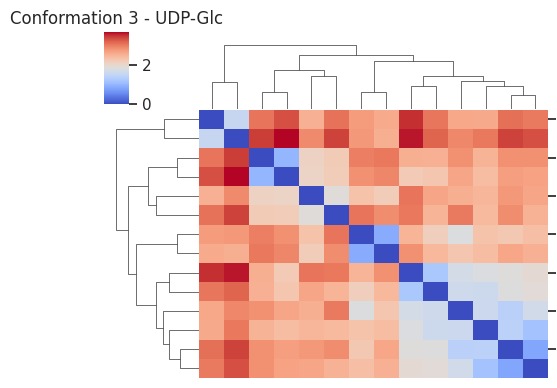

<ipython-input-87-0015f127ce11>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


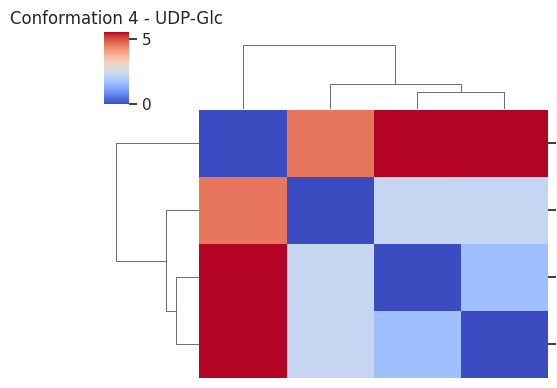

<ipython-input-87-0015f127ce11>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


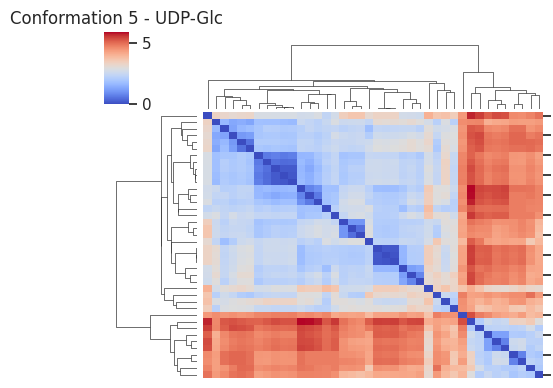

<ipython-input-87-0015f127ce11>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


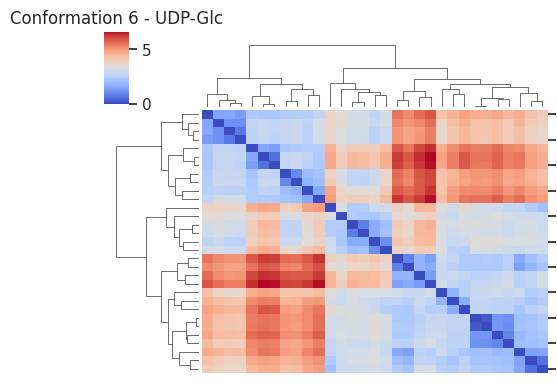

<ipython-input-87-0015f127ce11>:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


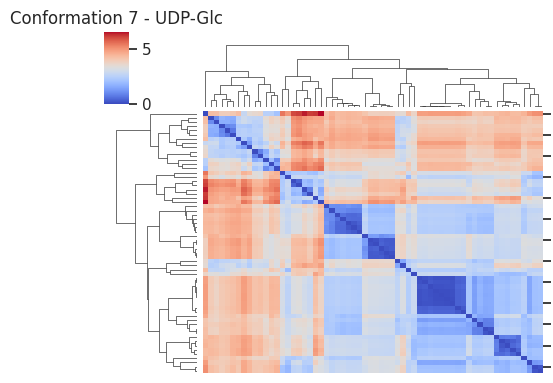

In [ ]:
conformation = 2
for poses, df in zip(filtered_glc, filtered_df_glc):
  if df.shape[0] > 0:
    filtered_file(poses, 'filtered_temp.sdf')

    rmsd_matrix = RMSD_matrix(df.shape[0], 'filtered_temp.sdf')

    os.remove('filtered_temp.sdf')

    # Calculate linkage
    linkage = hierarchy.linkage(rmsd_matrix, method='average')

    # Plot the combined heatmap and dendrogram
    cluster = sns.clustermap(rmsd_matrix, method='average', cmap='coolwarm', row_cluster=True, col_cluster=True, figsize=(5, 4))

    # Remove index labels on the axes
    cluster.ax_heatmap.set_xticklabels([])
    cluster.ax_heatmap.set_yticklabels([])

    # Set title and labels
    plt.title(f'Conformation {conformation} - UDP-Glc')

    # Show the plot
    plt.show()
  conformation = conformation + 1

**Clustering of the UDP-Glc poses**

<ipython-input-91-f7009e528fa0>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


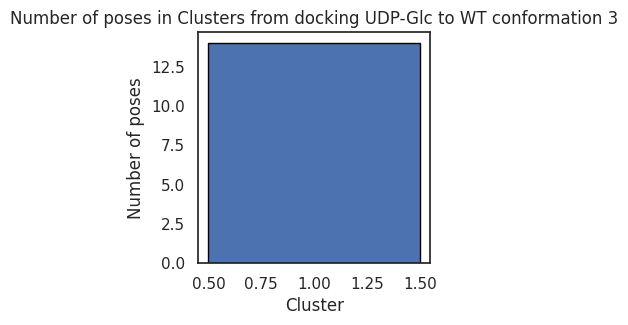

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.69398
Representative pose id: 83
CNN score of rep pose is 0.7268297672, distance is 5.492221883718834




<ipython-input-91-f7009e528fa0>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


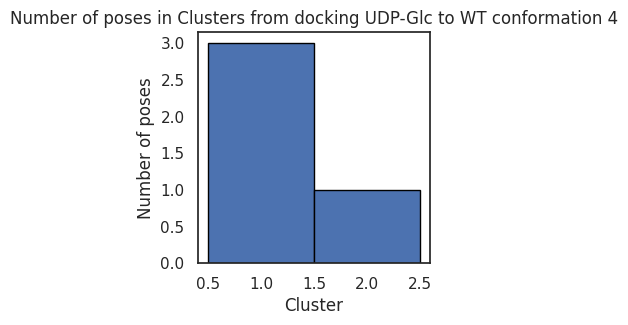

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 2.3086
Representative pose id: 182
CNN score of rep pose is 0.7521315813, distance is 7.468645387217143


-----------  cluster 2 ------------------------
Representative pose id: 125
Note! Only one pose in the cluster




<ipython-input-91-f7009e528fa0>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


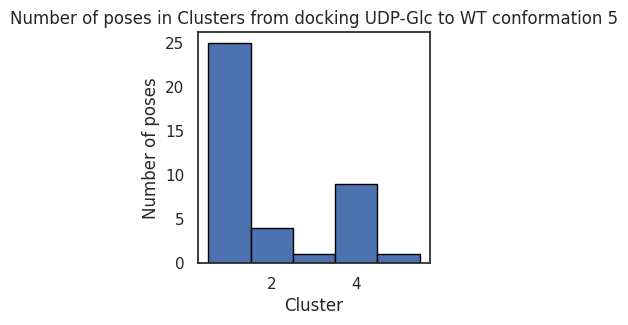

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.15856
Representative pose id: 46
CNN score of rep pose is 0.5207882524, distance is 10.71099004247506


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 3.69281
Representative pose id: 167
CNN score of rep pose is 0.5296247005, distance is 11.18133838276975


-----------  cluster 3 ------------------------
Representative pose id: 107
Note! Only one pose in the cluster


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 3.56689
Representative pose id: 21
CNN score of rep pose is 0.8255652785, distance is 11.0551816366806


-----------  cluster 5 ------------------------
Representative pose id: 73
Note! Only one pose in the cluster




<ipython-input-91-f7009e528fa0>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


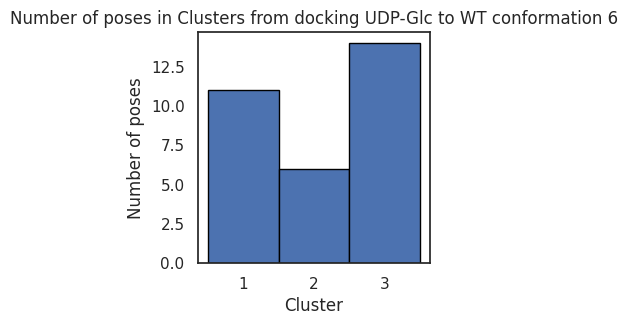

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.08631
Representative pose id: 29
CNN score of rep pose is 0.5274170637, distance is 7.529941046913977


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 3.20987
Representative pose id: 168
CNN score of rep pose is 0.534052968, distance is 8.755947120100716


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 3.1466
Representative pose id: 167
CNN score of rep pose is 0.5664327741, distance is 9.576089505116377




<ipython-input-91-f7009e528fa0>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


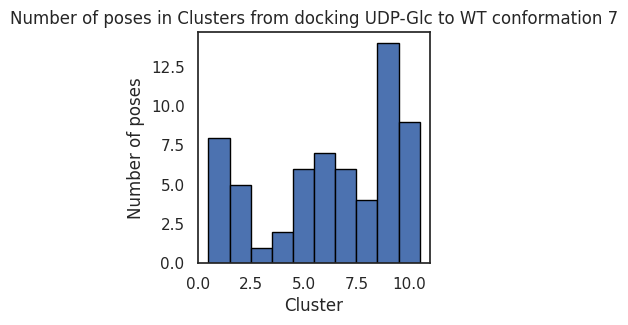

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 2.93325
Representative pose id: 3
CNN score of rep pose is 0.6114504337, distance is 10.25095133194963


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 2.76381
Representative pose id: 63
CNN score of rep pose is 0.5514936447, distance is 8.375047373597356


-----------  cluster 3 ------------------------
Representative pose id: 49
Note! Only one pose in the cluster


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 1.97227
Representative pose id: 21
CNN score of rep pose is 0.6038182378, distance is 10.37012957778252


-----------  cluster 5 ------------------------
Largest RMSD between two poses: 2.83403
Representative pose id: 5
CNN score of rep pose is 0.5596985221, distance is 10.55116626065574


-----------  cluster 6 ------------------------
Largest RMSD between two poses: 1.16712
Representative pose id: 66
CNN score of rep pose is 0.4989

In [ ]:
threshold = 7 # threshold for maximum distance when clustering
conformation = 2

for poses, df in zip(filtered_glc, filtered_df_glc):
  if df.shape[0] > 0:
    filtered_file(poses, 'filtered_temp.sdf')

    rmsd_matrix = RMSD_matrix(df.shape[0], 'filtered_temp.sdf')

    os.remove('filtered_temp.sdf')

    # Calculate linkage
    linkage = hierarchy.linkage(rmsd_matrix, method='average')

    df_temp = df.copy() # the dataframe with the scores for the poses that will be clustered
    poses_list = poses # the corresponding poses that should be clustered

    clusters = fcluster(linkage, threshold, criterion='distance')

    nbr_clusters = len(set(clusters))

    # Plot histogram
    plt.figure(figsize=(3, 3))
    plt.hist(clusters, bins=range(1, nbr_clusters+2), align='left', edgecolor='black')
    plt.xlabel('Cluster')
    plt.ylabel('Number of poses')
    plt.title(f'Number of poses in Clusters from docking UDP-Glc to WT conformation {conformation}')
    plt.show()

    df_temp.insert(1, "cluster", clusters, True)

    for c in range(1,nbr_clusters+1):
      nbr_c = clusters == c
      nbr_c = np.sum(nbr_c)

      if nbr_c > 1:
        poses = []
        pose_id = df_temp[df_temp['cluster'] == c]
        for p in poses_list:
          if int(p.GetProp('_Name')) in pose_id['id'].values:
            poses.append(p)
        filtered_file(poses, 'temp_poses.sdf')

        [rep_pose_mol, rmsd_matrix, rmsd_df] = representative_pose(poses, 'temp_poses.sdf')
        os.remove('temp_poses.sdf')

        print(f'-----------  cluster {c} ------------------------')
        print(f'Largest RMSD between two poses: {rmsd_matrix.max()}')

        mol_name = rep_pose_mol.GetProp('_Name')
        score_rep_pose = df_temp[df_temp['id'] == int(mol_name)]
        print(f'Representative pose id: {mol_name}')

        s = score_rep_pose['CNNscore'].values[0]
        d = score_rep_pose['distance'].values[0]
        print(f'CNN score of rep pose is {s}, distance is {d}')
        print('')
        print('')
      else:
        pose_id = df_temp[df_temp['cluster'] == c]
        pose_id = pose_id['id']
        print(f'-----------  cluster {c} ------------------------')
        print(f'Representative pose id: {pose_id.values[0]}')
        print('Note! Only one pose in the cluster')
        print('')
        print('')

  conformation = conformation + 1

# Analysis of poses from docking to the mutants

## Read in files

In [ ]:
proteins = ['mut1.pdb', 'mut2.pdb','mut3.pdb','mut4.pdb','mut5.pdb', 'mut6.pdb']
glcA_files = ['mut1_glcA.sdf', 'mut2_glcA.sdf','mut3_glcA.sdf','mut4_glcA.sdf','mut5_glcA.sdf', 'mut6_glcA.sdf']
glc_files = ['mut1_glc.sdf', 'mut2_glc.sdf','mut3_glc.sdf','mut4_glc.sdf','mut5_glc.sdf', 'mut6_glc.sdf']
score_file = 'mutants.xlsx'
sheet_names_glcA = ['mut1_glcA', 'mut2_glcA', 'mut3_glcA', 'mut4_glcA', 'mut5_glcA', 'mut6_glcA']
sheet_names_glc = ['mut1_glc', 'mut2_glc', 'mut3_glc', 'mut4_glc', 'mut5_glc', 'mut6_glc']

df_glcA = []
df_glc = []
glcA = []
glc = []

for l1, l2, sheet_name_glcA, sheet_name_glc in zip(glcA_files, glc_files, sheet_names_glcA, sheet_names_glc):

  df_glcA.append(pd.read_excel(score_file, sheet_name=sheet_name_glcA))
  glcA.append(Chem.SDMolSupplier(l1))

  df_glc.append(pd.read_excel(score_file, sheet_name=sheet_name_glc))
  glc.append(Chem.SDMolSupplier(l2))

## Filter poses

Filter the docked UDP-GlcA and UDP-Glc poses based on the CNN score and the uridine RMSD.

In [ ]:
filtered_glcA = []
filtered_glc = []
filtered_df_glcA = []
filtered_df_glc = []

RMSD_min = 0
RMSD_max = 2
CNN_max = 1

mutant = 1

for l1, l2, l1_df, l2_df in zip(glcA, glc, df_glcA, df_glc):
  print(f'Mutant {mutant}:')

  # filter UDP-GlcA (based on both RMSD and CNN score)
  print('UDP-GlcA: ')
  CNN_min = l1_df['CNNscore'].median() # minimum CNN score = the median CNN score
  [filtered_poses, filtered_df] = filtering(l1, l1_df, ['RMSD', RMSD_min, RMSD_max], ['CNNscore', CNN_min, CNN_max])
  filtered_df_glcA.append(filtered_df)
  filtered_glcA.append(filtered_poses)

  # filter UDP-Glc (based on both RMSD and CNN score)
  print('UDP-Glc: ')
  CNN_min = l2_df['CNNscore'].median() # minimum CNN score = the median CNN score
  [filtered_poses, filtered_df] = filtering(l2, l2_df, ['RMSD', RMSD_min, RMSD_max], ['CNNscore', CNN_min, CNN_max])
  filtered_df_glc.append(filtered_df)
  filtered_glc.append(filtered_poses)

  print('----------------------------------------------------------------------\n')
  mutant = mutant + 1


Mutant 1:
UDP-GlcA: 
number of filtered poses: 53, which is 26.5 % of the poses

UDP-Glc: 
number of filtered poses: 54, which is 27.0 % of the poses

----------------------------------------------------------------------

Mutant 2:
UDP-GlcA: 
number of filtered poses: 61, which is 30.5 % of the poses

UDP-Glc: 
number of filtered poses: 59, which is 29.5 % of the poses

----------------------------------------------------------------------

Mutant 3:
UDP-GlcA: 
number of filtered poses: 86, which is 43.0 % of the poses

UDP-Glc: 
number of filtered poses: 81, which is 40.5 % of the poses

----------------------------------------------------------------------

Mutant 4:
UDP-GlcA: 
number of filtered poses: 62, which is 31.0 % of the poses

UDP-Glc: 
number of filtered poses: 80, which is 40.0 % of the poses

----------------------------------------------------------------------

Mutant 5:
UDP-GlcA: 
number of filtered poses: 88, which is 44.0 % of the poses

UDP-Glc: 
number of filtere

## Density plots of distance vs docking score

The following cells give the density plots of the distance vs CNN score and  distance vs Vina score for the filtered UDP-Glc and UDP-GlcA from docking to the different mutants.

**Distance vs Vina score**

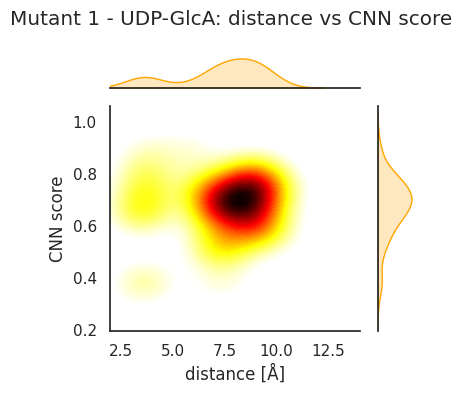

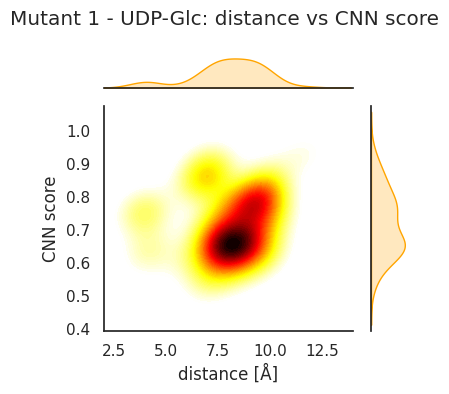

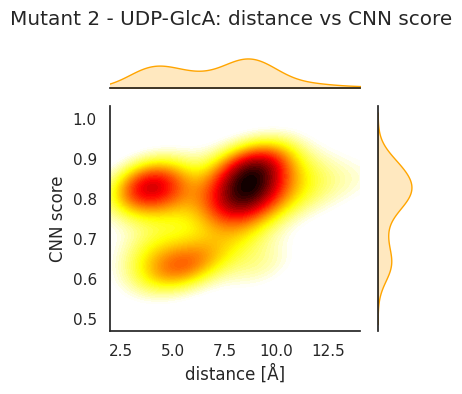

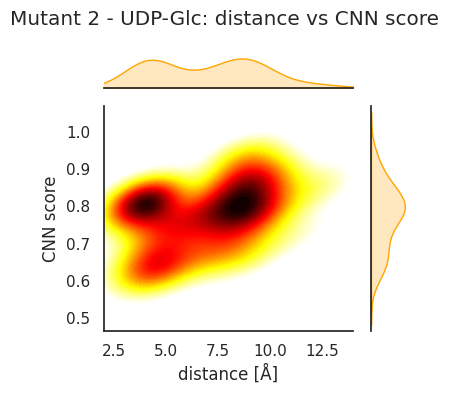

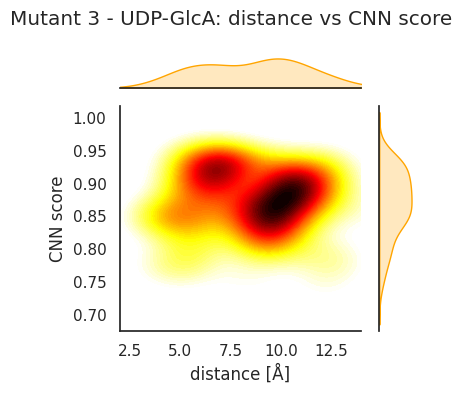

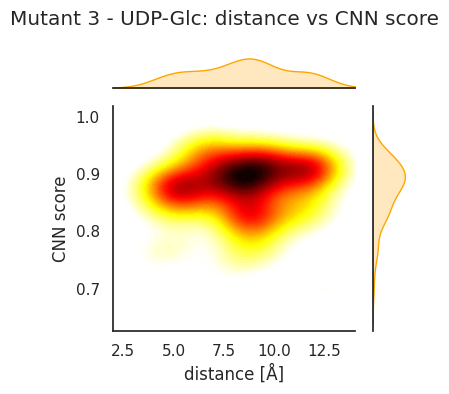

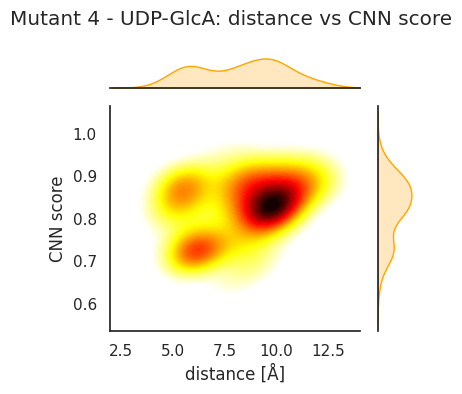

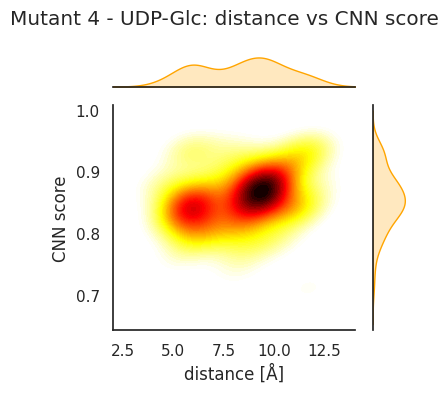

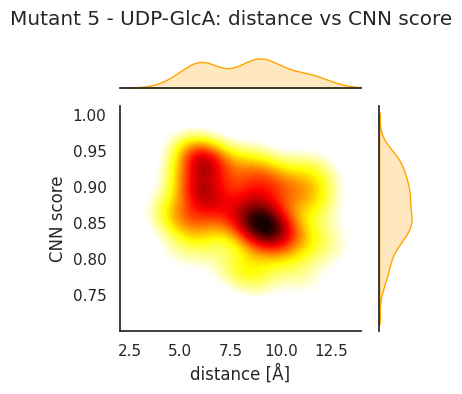

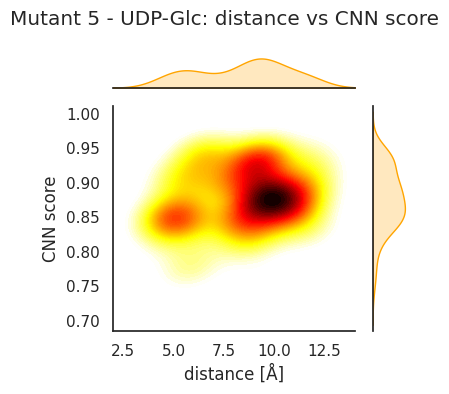

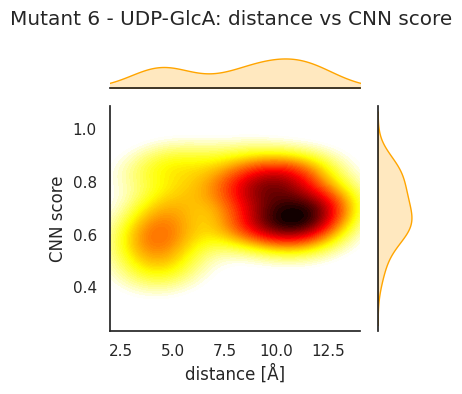

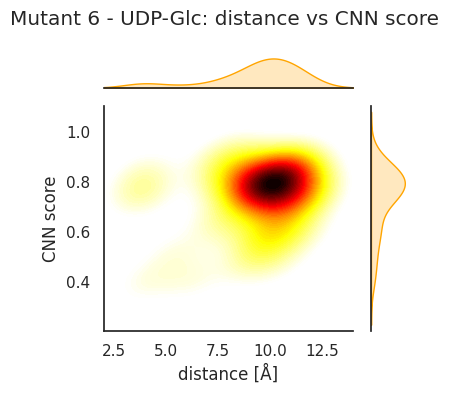

In [ ]:
mutant = 1

# goes through all the filtered UDP-GlcA and UDP-Glc poses from docking to the different mutants
for l1, l2 in zip(filtered_df_glcA, filtered_df_glc):
  # check if the number of filtered poses is more than 5
  if len(l1) > 5:
    sns.set(style="white")

    f = sns.jointplot(x=l1['distance'],
                      y=l1['CNNscore'],
                      kind='kde',
                      cmap='hot_r',
                      n_levels=60,
                      fill=True,
                      marginal_kws=dict(color="orange"),
                      xlim=(2, 14),
                      height=4)
    f.set_axis_labels("distance [Å]", "CNN score")
    f.fig.suptitle(f'Mutant {mutant} - UDP-GlcA: distance vs CNN score')
    plt.tight_layout()
    plt.show()

    if len(l2) > 5:
      sns.set(style="white")

      f = sns.jointplot(x=l2['distance'],
                        y=l2['CNNscore'],
                        kind='kde',
                        cmap='hot_r',
                        n_levels=60,
                        fill=True,
                        marginal_kws=dict(color="orange"),
                        xlim=(2, 14),
                        height=4)
      f.set_axis_labels("distance [Å]", "CNN score")
      f.fig.suptitle(f'Mutant {mutant} - UDP-Glc: distance vs CNN score')
      plt.tight_layout()
      plt.show()

    mutant = mutant + 1



**Distance vs Vina score**

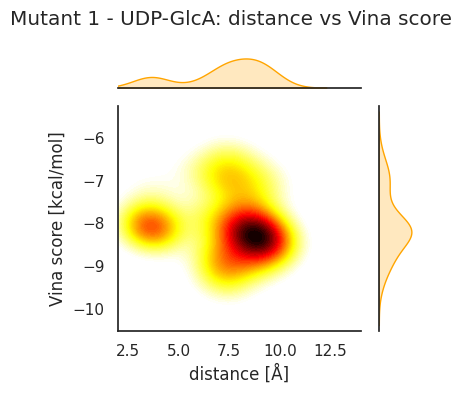

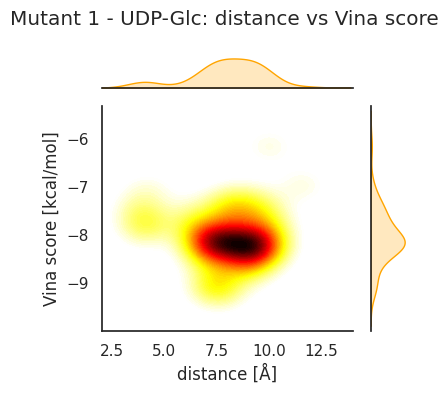

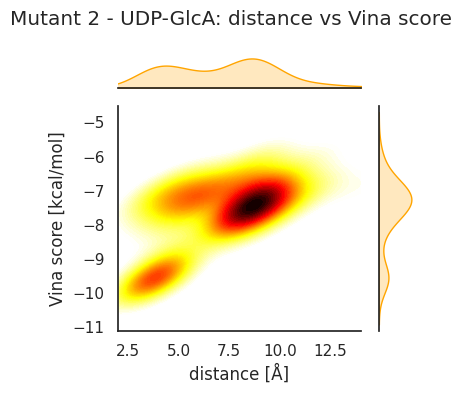

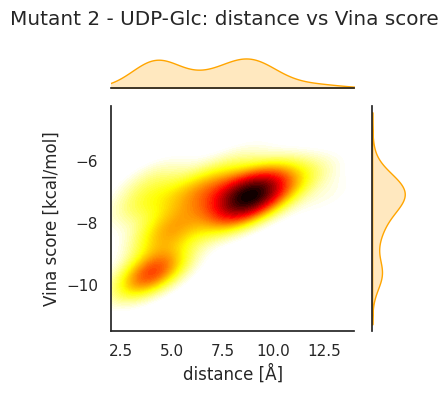

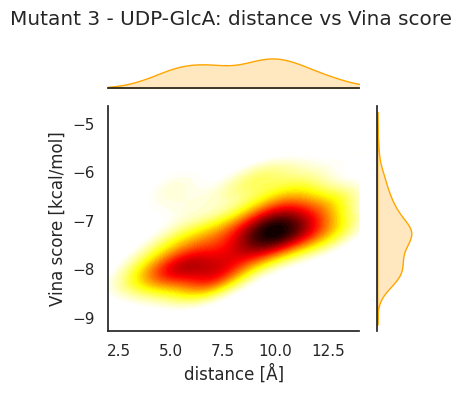

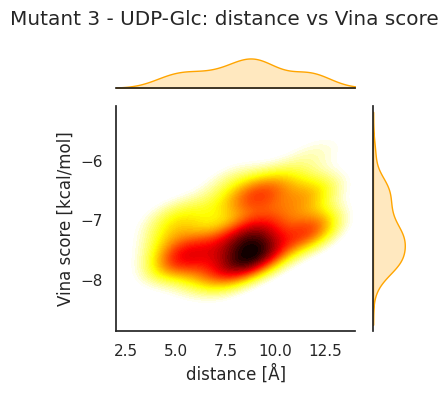

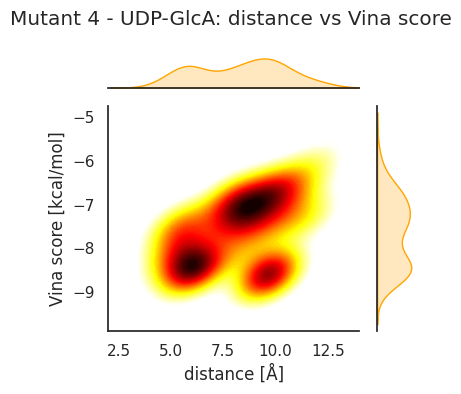

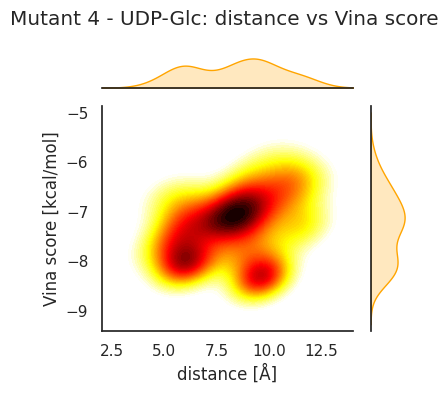

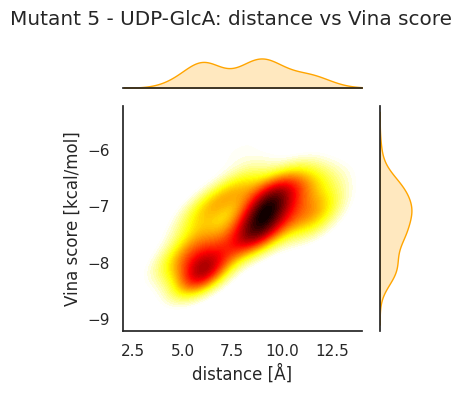

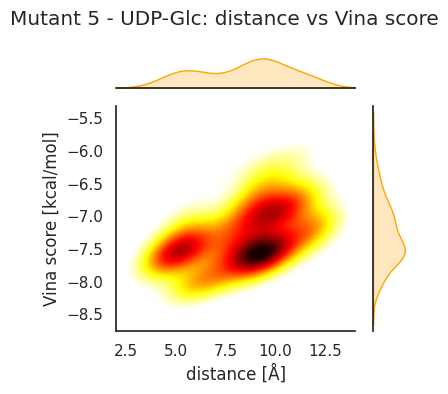

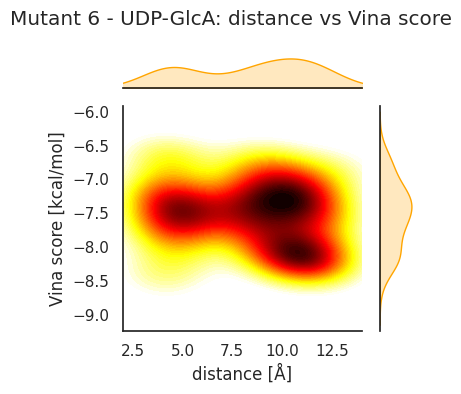

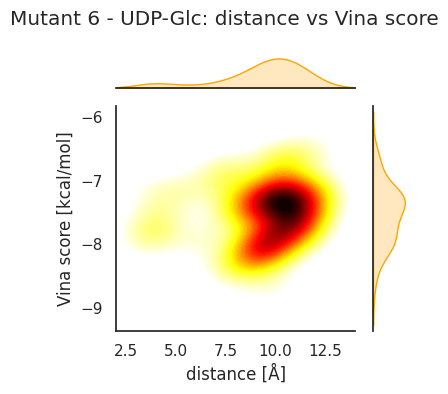

In [ ]:
mutant = 1

# goes through all the filtered UDP-GlcA and UDP-Glc poses from docking to the different mutants
for l1, l2 in zip(filtered_df_glcA, filtered_df_glc):
  # check if the number of filtered poses is more than 5
  if len(l1) > 5:
    sns.set(style="white")

    f = sns.jointplot(x=l1['distance'],
                      y=l1['Vina'],
                      kind='kde',
                      cmap='hot_r',
                      n_levels=60,
                      fill=True,
                      marginal_kws=dict(color="orange"),
                      xlim=(2, 14),
                      height=4)
    f.set_axis_labels("distance [Å]", "Vina score [kcal/mol]")
    f.fig.suptitle(f'Mutant {mutant} - UDP-GlcA: distance vs Vina score')
    plt.tight_layout()
    plt.show()

    if len(l2) > 5:
      sns.set(style="white")

      f = sns.jointplot(x=l2['distance'],
                        y=l2['Vina'],
                        kind='kde',
                        cmap='hot_r',
                        n_levels=60,
                        fill=True,
                        marginal_kws=dict(color="orange"),
                        xlim=(2, 14),
                        height=4)
      f.set_axis_labels("distance [Å]", "Vina score [kcal/mol]")
      f.fig.suptitle(f'Mutant {mutant} - UDP-Glc: distance vs Vina score')
      plt.tight_layout()
      plt.show()

    mutant = mutant + 1


## Plot of dihedrals

The follow cell plots the dihedral angles for the UDP-GlcA and UDP-Glc poses from docking to the different mutants.

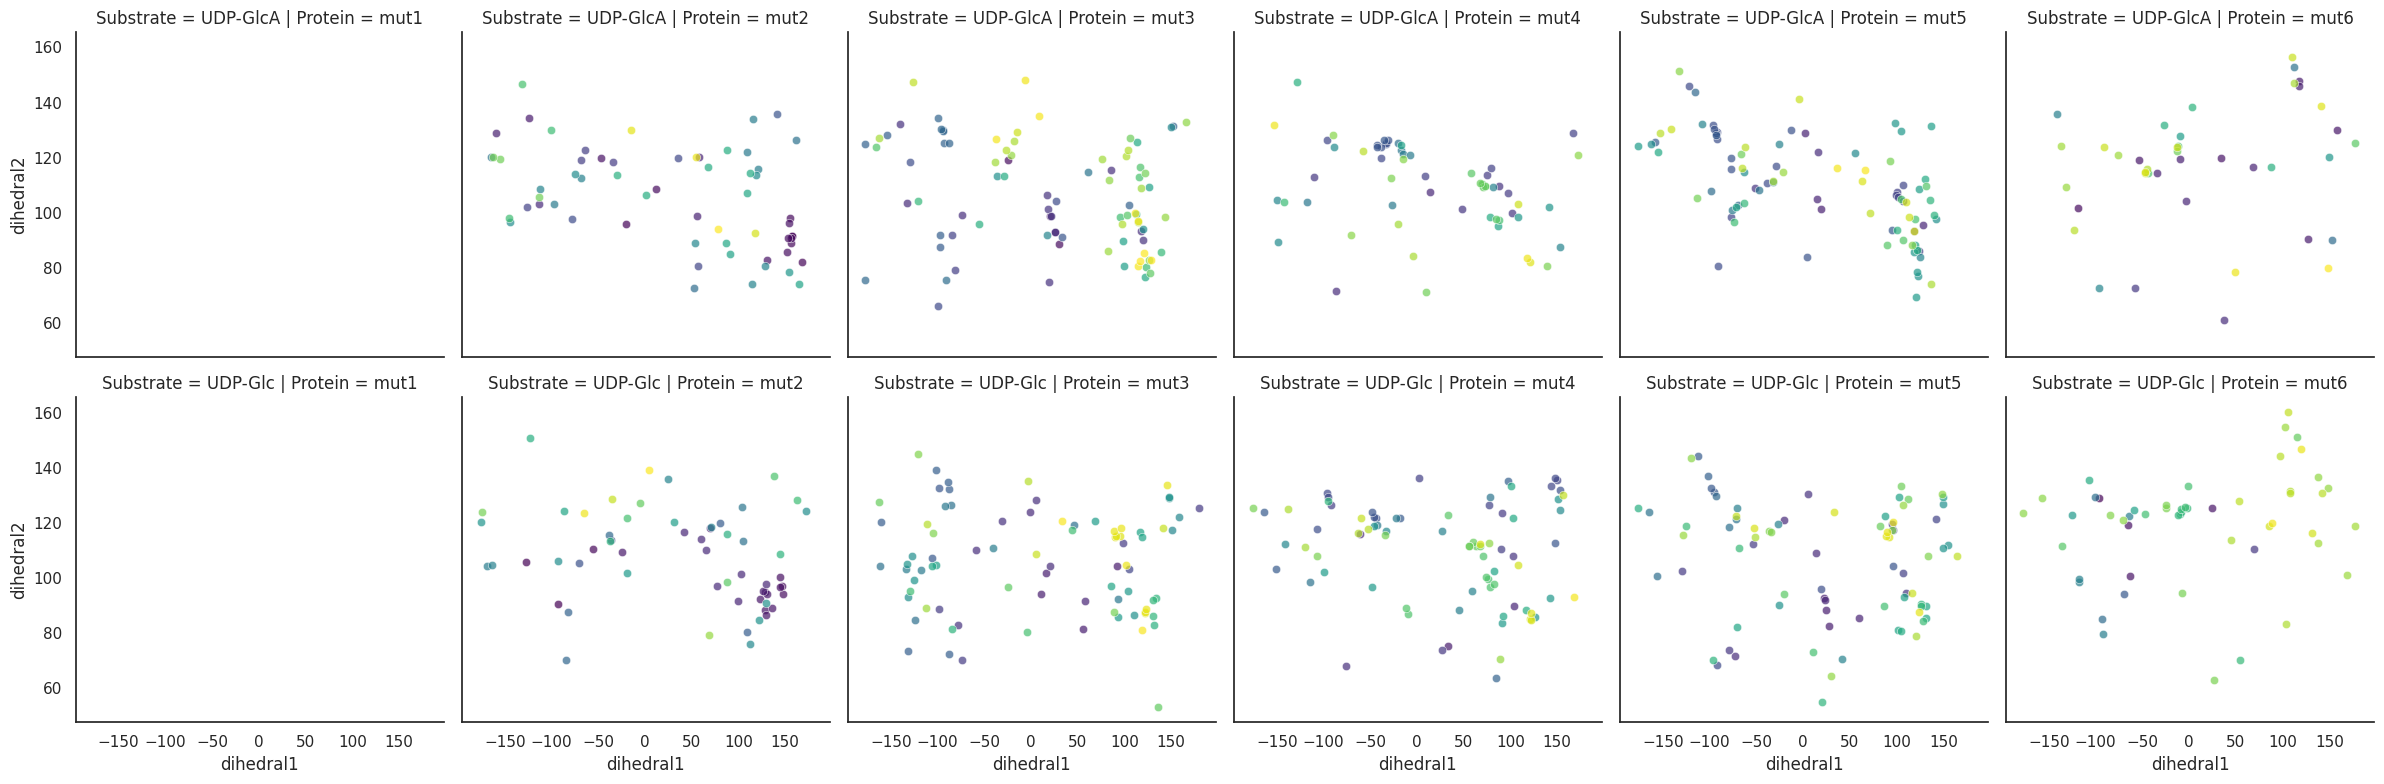

In [ ]:
merged = pd.DataFrame()

for l1, l2 in zip(filtered_df_glcA, filtered_df_glc):
  merged = pd.concat((merged, l1), axis=0)
  merged = pd.concat((merged, l2), axis=0)
g = sns.FacetGrid(merged, col="Protein",row='Substrate', hue="distance", palette='viridis',  height=4)
g.map(sns.scatterplot, "dihedral1", "dihedral2", alpha=.7)

## Heatmaps and clustering based on pairwise RMSD

In the following cells, the pairwise RMSD for all the filtered poses for each substrate is calculated and displayed as a heatmap (a graphical representation of the calculated values). Based on the calculated pairwise RMSD, the poses are clustered with hierarchical clustering (using the scipy kit). The linkage method used to calculate the distance between the clusters is 'average', and these distances are represented by a dendrogram. The clusters are formed by grouping all poses with a distance of maximum 7.

More information about the clustering method used can be found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html




### UDP-GlcA:

**Displaying heatmap and dendrograms**

<ipython-input-8-ebc6e0763474>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


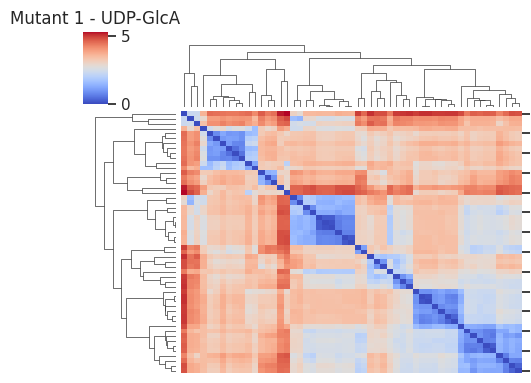

<ipython-input-8-ebc6e0763474>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


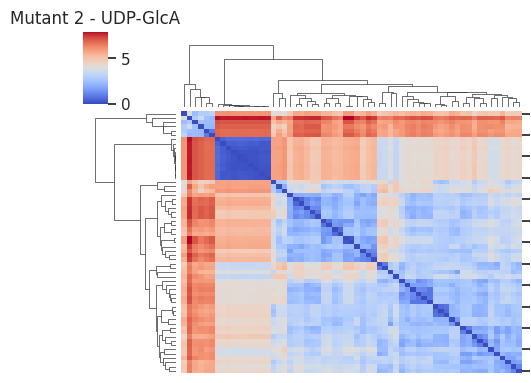

<ipython-input-8-ebc6e0763474>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


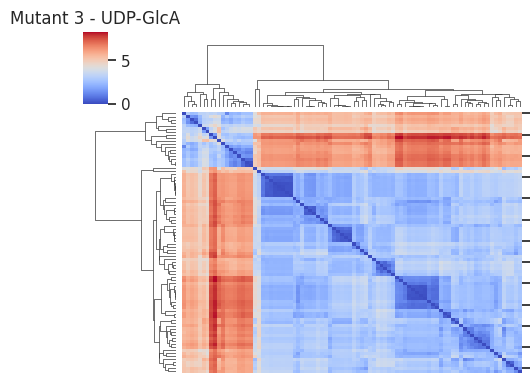

<ipython-input-8-ebc6e0763474>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


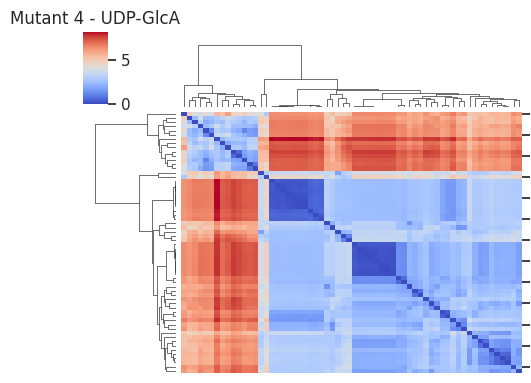

<ipython-input-8-ebc6e0763474>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


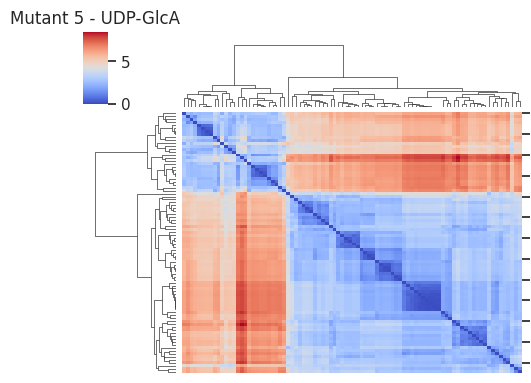

<ipython-input-8-ebc6e0763474>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


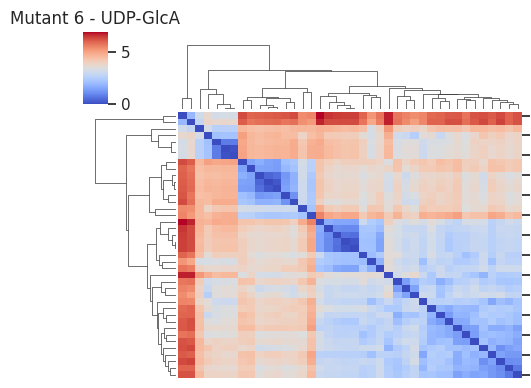

In [ ]:
mutant = 1

for poses, df in zip(filtered_glcA, filtered_df_glcA):
  if df.shape[0] > 0:
    filtered_file(poses, 'filtered_temp.sdf')

    rmsd_matrix = RMSD_matrix(df.shape[0], 'filtered_temp.sdf')

    os.remove('filtered_temp.sdf')

    # Calculate linkage
    linkage = hierarchy.linkage(rmsd_matrix, method='average')

    # Plot the combined heatmap and dendrogram
    cluster = sns.clustermap(rmsd_matrix, method='average', cmap='coolwarm', row_cluster=True, col_cluster=True, figsize=(5, 4))

    # Remove index labels on the axes
    cluster.ax_heatmap.set_xticklabels([])
    cluster.ax_heatmap.set_yticklabels([])

    # Set title and labels
    plt.title(f'Mutant {mutant} - UDP-GlcA')

    # Show the plot
    plt.show()
  mutant = mutant + 1

**Clustering based on the pairwise RMSD for the docked UDP-GlcA:**


<ipython-input-10-0371d510d13b>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


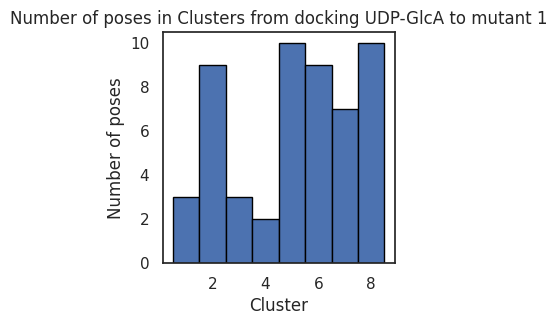

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 2.39818
Representative pose id: 24
CNN score of rep pose is 0.6604489684, distance is 7.418703002547012


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 2.8977
Representative pose id: 82
CNN score of rep pose is 0.7919102907, distance is 3.774167761242211


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 1.41994
Representative pose id: 66
CNN score of rep pose is 0.4921521246, distance is 7.28816571230375


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 2.87893
Representative pose id: 94
CNN score of rep pose is 0.3714750707, distance is 3.737415346198493


-----------  cluster 5 ------------------------
Largest RMSD between two poses: 1.97281
Representative pose id: 122
CNN score of rep pose is 0.7110804915, distance is 7.808963654672756


-----------  cluster 6 ------------------------
Largest RMSD between tw

<ipython-input-10-0371d510d13b>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


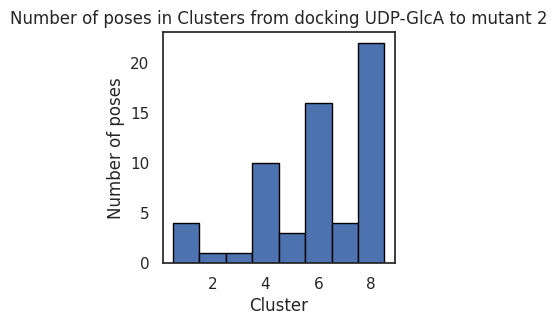

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 2.45622
Representative pose id: 123
CNN score of rep pose is 0.7994502783, distance is 11.83784349448834


-----------  cluster 2 ------------------------
Representative pose id: 4
Note! Only one pose in the cluster


-----------  cluster 3 ------------------------
Representative pose id: 148
Note! Only one pose in the cluster


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 0.606793
Representative pose id: 146
CNN score of rep pose is 0.8361020684, distance is 3.772839316748065


-----------  cluster 5 ------------------------
Largest RMSD between two poses: 2.86463
Representative pose id: 41
CNN score of rep pose is 0.8951678872, distance is 7.365955787268878


-----------  cluster 6 ------------------------
Largest RMSD between two poses: 3.01193
Representative pose id: 125
CNN score of rep pose is 0.7810502648, distance is 9.911240710930182


-----------  cluster 7 -----

<ipython-input-10-0371d510d13b>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


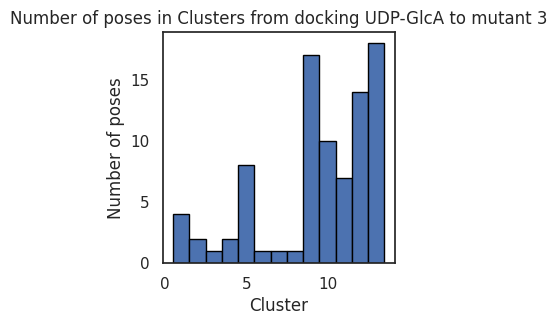

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.10011
Representative pose id: 132
CNN score of rep pose is 0.8149999976, distance is 9.052326804750262


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 1.68809
Representative pose id: 26
CNN score of rep pose is 0.8472240567, distance is 8.508882187455653


-----------  cluster 3 ------------------------
Representative pose id: 171
Note! Only one pose in the cluster


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 1.57252
Representative pose id: 87
CNN score of rep pose is 0.7933431268, distance is 12.45813003464003


-----------  cluster 5 ------------------------
Largest RMSD between two poses: 2.80884
Representative pose id: 122
CNN score of rep pose is 0.9277846813, distance is 12.49884597312888


-----------  cluster 6 ------------------------
Representative pose id: 66
Note! Only one pose in the cluster


-----------  cluster 7 ------

<ipython-input-10-0371d510d13b>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


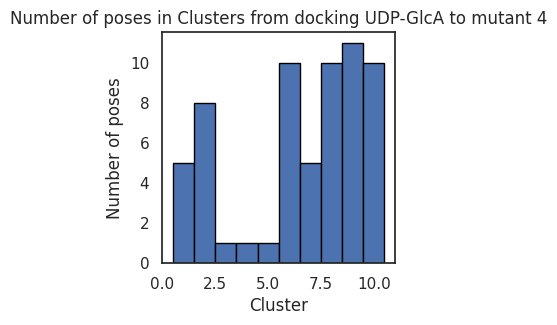

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.78163
Representative pose id: 101
CNN score of rep pose is 0.9333885312, distance is 9.913576580124854


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 3.31748
Representative pose id: 141
CNN score of rep pose is 0.9213101864, distance is 11.5888028846814


-----------  cluster 3 ------------------------
Representative pose id: 45
Note! Only one pose in the cluster


-----------  cluster 4 ------------------------
Representative pose id: 51
Note! Only one pose in the cluster


-----------  cluster 5 ------------------------
Representative pose id: 82
Note! Only one pose in the cluster


-----------  cluster 6 ------------------------
Largest RMSD between two poses: 0.588199
Representative pose id: 184
CNN score of rep pose is 0.8192990422, distance is 9.72898373778063


-----------  cluster 7 ------------------------
Largest RMSD between two poses: 3.34154
Representative p

<ipython-input-10-0371d510d13b>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


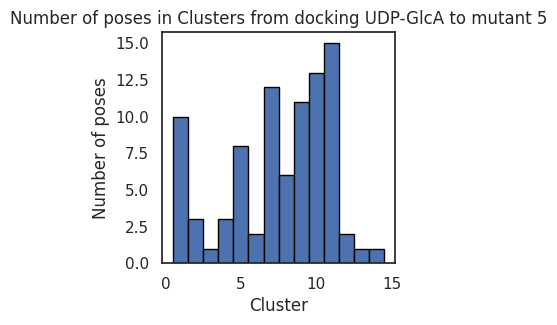

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.67647
Representative pose id: 8
CNN score of rep pose is 0.7941966653, distance is 8.588584174938273


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 1.8831
Representative pose id: 125
CNN score of rep pose is 0.8611326218, distance is 8.473400999008602


-----------  cluster 3 ------------------------
Representative pose id: 2
Note! Only one pose in the cluster


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 2.35237
Representative pose id: 152
CNN score of rep pose is 0.7870179415, distance is 10.87581762535581


-----------  cluster 5 ------------------------
Largest RMSD between two poses: 2.27453
Representative pose id: 43
CNN score of rep pose is 0.9268139005, distance is 11.57805169188668


-----------  cluster 6 ------------------------
Largest RMSD between two poses: 2.24014
Representative pose id: 65
CNN score of rep pose is 0.834

<ipython-input-10-0371d510d13b>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


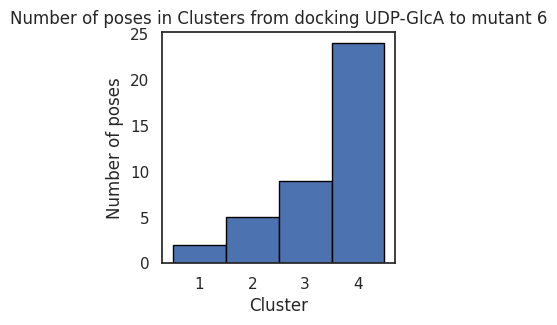

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 1.92415
Representative pose id: 2
CNN score of rep pose is 0.7094037533, distance is 12.77459801


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 3.19003
Representative pose id: 145
CNN score of rep pose is 0.6086803079, distance is 7.710863003


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 3.21586
Representative pose id: 21
CNN score of rep pose is 0.6421496272, distance is 11.00509307


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 3.94051
Representative pose id: 181
CNN score of rep pose is 0.861158371, distance is 9.194002346




In [ ]:
threshold = 7 # threshold for maximum distance when clustering
mutant = 1

for poses, df in zip(filtered_glcA, filtered_df_glcA):
  if df.shape[0] > 0:
    filtered_file(poses, 'filtered_temp.sdf')

    rmsd_matrix = RMSD_matrix(df.shape[0], 'filtered_temp.sdf')

    os.remove('filtered_temp.sdf')

    # Calculate linkage
    linkage = hierarchy.linkage(rmsd_matrix, method='average')

    df_temp = df.copy() # the dataframe with the scores for the poses that will be clustered
    poses_list = poses # the corresponding poses that should be clustered

    clusters = fcluster(linkage, threshold, criterion='distance')

    nbr_clusters = len(set(clusters))

    # Plot histogram
    plt.figure(figsize=(3, 3))
    plt.hist(clusters, bins=range(1, nbr_clusters+2), align='left', edgecolor='black')
    plt.xlabel('Cluster')
    plt.ylabel('Number of poses')
    plt.title(f'Number of poses in Clusters from docking UDP-GlcA to mutant {mutant}')
    plt.show()

    df_temp.insert(1, "cluster", clusters, True)

    for c in range(1,nbr_clusters+1):
      nbr_c = clusters == c
      nbr_c = np.sum(nbr_c)

      if nbr_c > 1:
        poses = []
        pose_id = df_temp[df_temp['cluster'] == c]
        for p in poses_list:
          if int(p.GetProp('_Name')) in pose_id['id'].values:
            poses.append(p)
        filtered_file(poses, 'temp_poses.sdf')

        [rep_pose_mol, rmsd_matrix, rmsd_df] = representative_pose(poses, 'temp_poses.sdf')
        os.remove('temp_poses.sdf')

        print(f'-----------  cluster {c} ------------------------')
        print(f'Largest RMSD between two poses: {rmsd_matrix.max()}')

        mol_name = rep_pose_mol.GetProp('_Name')
        score_rep_pose = df_temp[df_temp['id'] == int(mol_name)]
        print(f'Representative pose id: {mol_name}')

        s = score_rep_pose['CNNscore'].values[0]
        d = score_rep_pose['distance'].values[0]
        print(f'CNN score of rep pose is {s}, distance is {d}')
        print('')
        print('')
      else:
        pose_id = df_temp[df_temp['cluster'] == c]
        pose_id = pose_id['id']
        print(f'-----------  cluster {c} ------------------------')
        print(f'Representative pose id: {pose_id.values[0]}')
        print('Note! Only one pose in the cluster')
        print('')
        print('')

  mutant = mutant + 1

###UDP-Glc:

**Displaying heatmap and dendrograms**

<ipython-input-9-91dfc3320ff4>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


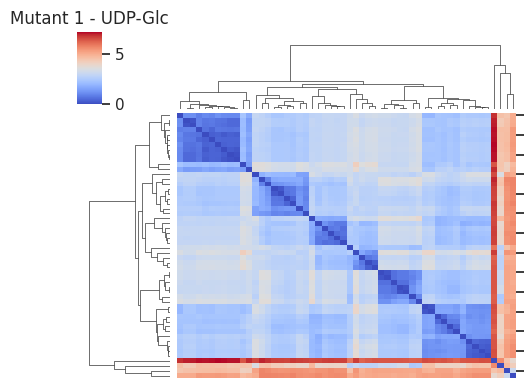

<ipython-input-9-91dfc3320ff4>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


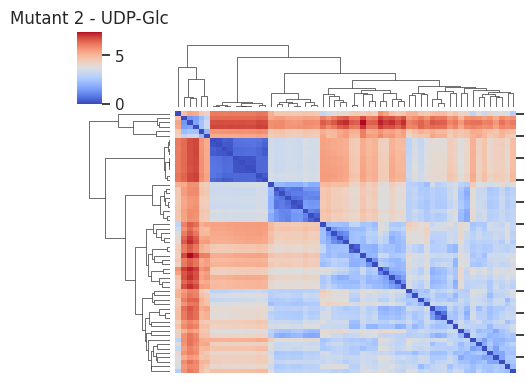

<ipython-input-9-91dfc3320ff4>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


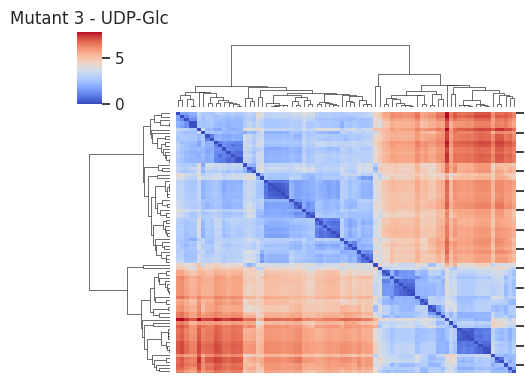

<ipython-input-9-91dfc3320ff4>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


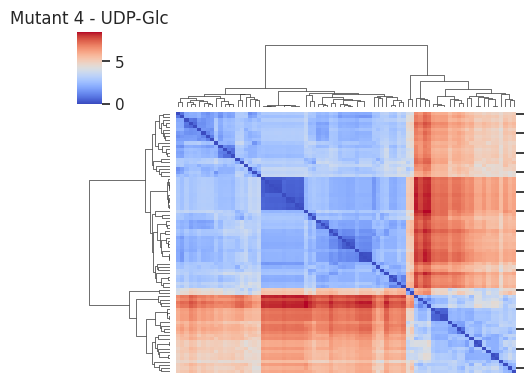

<ipython-input-9-91dfc3320ff4>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


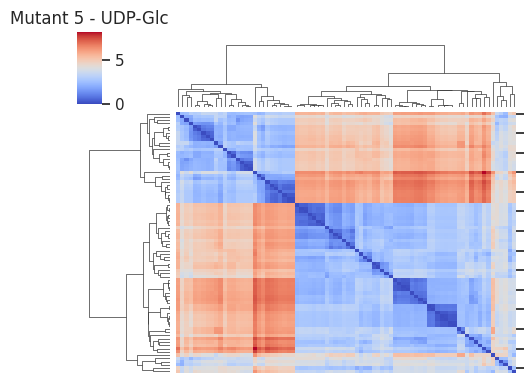

<ipython-input-9-91dfc3320ff4>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


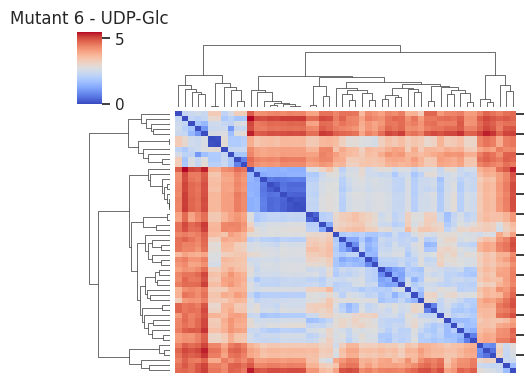

In [ ]:
mutant = 1

for poses, df in zip(filtered_glc, filtered_df_glc):
  if df.shape[0] > 0:
    filtered_file(poses, 'filtered_temp.sdf')

    rmsd_matrix = RMSD_matrix(df.shape[0], 'filtered_temp.sdf')

    os.remove('filtered_temp.sdf')

    # Calculate linkage
    linkage = hierarchy.linkage(rmsd_matrix, method='average')

    # Plot the combined heatmap and dendrogram
    cluster = sns.clustermap(rmsd_matrix, method='average', cmap='coolwarm', row_cluster=True, col_cluster=True, figsize=(5, 4))

    # Remove index labels on the axes
    cluster.ax_heatmap.set_xticklabels([])
    cluster.ax_heatmap.set_yticklabels([])

    # Set title and labels
    plt.title(f'Mutant {mutant} - UDP-Glc')

    # Show the plot
    plt.show()
  mutant = mutant + 1

**Clustering based on the pairwise RMSD for the docked UDP-Glc:**

<ipython-input-12-361086f164c9>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


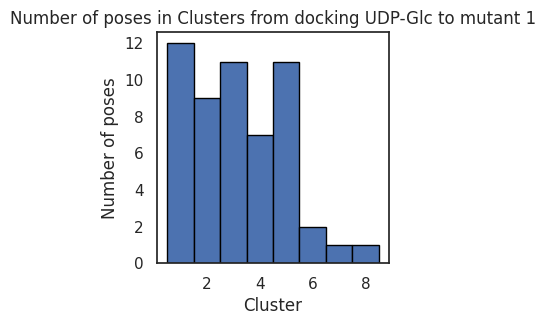

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 2.32296
Representative pose id: 85
CNN score of rep pose is 0.6528334618, distance is 7.835959449231476


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 2.09837
Representative pose id: 41
CNN score of rep pose is 0.8200343251, distance is 9.751438790763137


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 3.30929
Representative pose id: 121
CNN score of rep pose is 0.8726302981, distance is 7.048773149279245


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 1.63696
Representative pose id: 127
CNN score of rep pose is 0.6093449593, distance is 7.375245498286821


-----------  cluster 5 ------------------------
Largest RMSD between two poses: 1.88555
Representative pose id: 164
CNN score of rep pose is 0.6410841346, distance is 8.919236780128667


-----------  cluster 6 ------------------------
Largest RMSD betwee

<ipython-input-12-361086f164c9>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


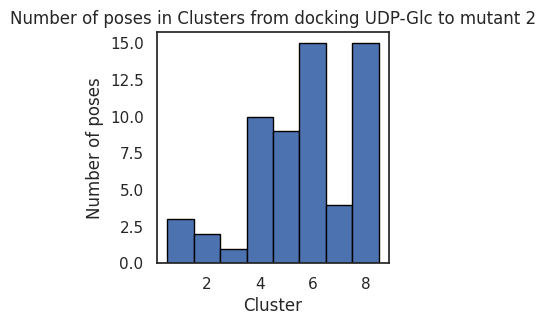

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 1.6073
Representative pose id: 85
CNN score of rep pose is 0.7301968336, distance is 11.46398285980923


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 2.00486
Representative pose id: 41
CNN score of rep pose is 0.8820042014, distance is 10.49311293420594


-----------  cluster 3 ------------------------
Representative pose id: 165
Note! Only one pose in the cluster


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 0.748912
Representative pose id: 142
CNN score of rep pose is 0.7784305215, distance is 4.062160357494521


-----------  cluster 5 ------------------------
Largest RMSD between two poses: 2.13906
Representative pose id: 9
CNN score of rep pose is 0.6579312682, distance is 4.796240633037502


-----------  cluster 6 ------------------------
Largest RMSD between two poses: 3.86708
Representative pose id: 1
CNN score of rep pose is 0.94

<ipython-input-12-361086f164c9>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


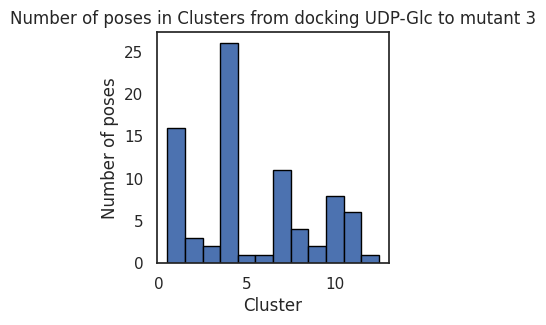

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.47519
Representative pose id: 161
CNN score of rep pose is 0.9458703399, distance is 6.66110611235101


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 2.16454
Representative pose id: 141
CNN score of rep pose is 0.9258794188, distance is 9.77052660760924


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 2.11693
Representative pose id: 186
CNN score of rep pose is 0.8484909534, distance is 7.566960251646631


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 3.20181
Representative pose id: 86
CNN score of rep pose is 0.8839784861, distance is 4.973649351331475


-----------  cluster 5 ------------------------
Representative pose id: 128
Note! Only one pose in the cluster


-----------  cluster 6 ------------------------
Representative pose id: 162
Note! Only one pose in the cluster


-----------  cluster 7 ------

<ipython-input-12-361086f164c9>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


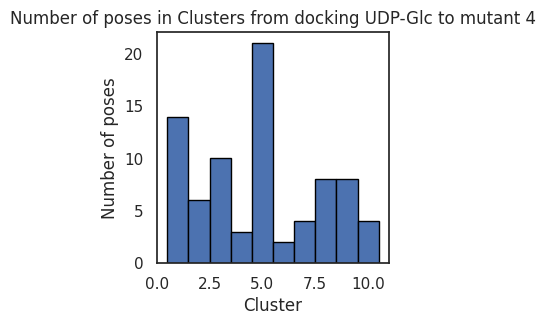

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 3.12455
Representative pose id: 165
CNN score of rep pose is 0.8299686909, distance is 7.73835988436826


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 3.47763
Representative pose id: 26
CNN score of rep pose is 0.8470242023, distance is 6.385304211233795


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 0.538173
Representative pose id: 63
CNN score of rep pose is 0.8663163781, distance is 9.574110845921936


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 2.52463
Representative pose id: 161
CNN score of rep pose is 0.8749322295, distance is 8.790402614783922


-----------  cluster 5 ------------------------
Largest RMSD between two poses: 3.15243
Representative pose id: 61
CNN score of rep pose is 0.9274742603, distance is 5.966733706141071


-----------  cluster 6 ------------------------
Largest RMSD between

<ipython-input-12-361086f164c9>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


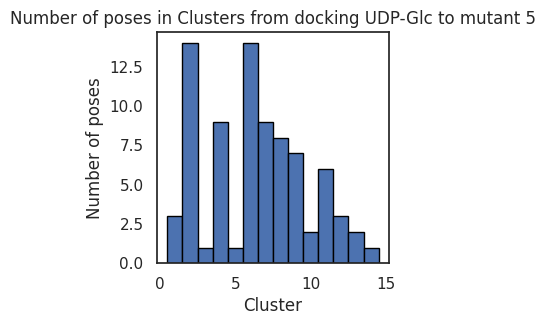

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 1.92374
Representative pose id: 181
CNN score of rep pose is 0.9480010271, distance is 9.36430570891404


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 3.21201
Representative pose id: 46
CNN score of rep pose is 0.8704274297, distance is 10.16390434331218


-----------  cluster 3 ------------------------
Representative pose id: 66
Note! Only one pose in the cluster


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 2.06598
Representative pose id: 102
CNN score of rep pose is 0.8942542076, distance is 11.84687787815845


-----------  cluster 5 ------------------------
Representative pose id: 105
Note! Only one pose in the cluster


-----------  cluster 6 ------------------------
Largest RMSD between two poses: 2.21592
Representative pose id: 85
CNN score of rep pose is 0.8406743407, distance is 4.592298075038251


-----------  cluster 7 -------

<ipython-input-12-361086f164c9>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(rmsd_matrix, method='average')


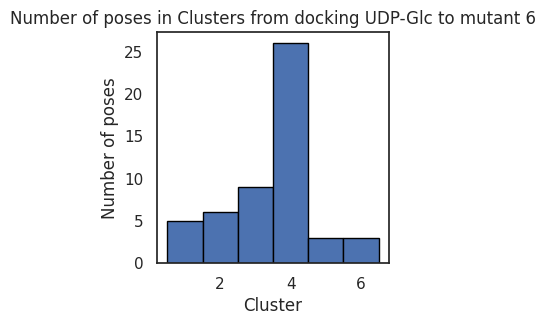

-----------  cluster 1 ------------------------
Largest RMSD between two poses: 2.48179
Representative pose id: 127
CNN score of rep pose is 0.6058542728, distance is 10.16814795329022


-----------  cluster 2 ------------------------
Largest RMSD between two poses: 2.89316
Representative pose id: 105
CNN score of rep pose is 0.7449834347, distance is 12.07242309149245


-----------  cluster 3 ------------------------
Largest RMSD between two poses: 1.57008
Representative pose id: 124
CNN score of rep pose is 0.7708223462, distance is 9.30906608044008


-----------  cluster 4 ------------------------
Largest RMSD between two poses: 3.63486
Representative pose id: 22
CNN score of rep pose is 0.842161119, distance is 10.97354146162487


-----------  cluster 5 ------------------------
Largest RMSD between two poses: 0.894156
Representative pose id: 142
CNN score of rep pose is 0.7714328766, distance is 3.720909224907272


-----------  cluster 6 ------------------------
Largest RMSD betwee

In [ ]:
threshold = 7 # threshold for maximum distance when clustering
mutant = 1

for poses, df in zip(filtered_glc, filtered_df_glc):
  if df.shape[0] > 0:
    filtered_file(poses, 'filtered_temp.sdf')

    rmsd_matrix = RMSD_matrix(df.shape[0], 'filtered_temp.sdf')

    os.remove('filtered_temp.sdf')

    # Calculate linkage
    linkage = hierarchy.linkage(rmsd_matrix, method='average')

    df_temp = df.copy() # the dataframe with the scores for the poses that will be clustered
    poses_list = poses # the corresponding poses that should be clustered

    clusters = fcluster(linkage, threshold, criterion='distance')

    nbr_clusters = len(set(clusters))

    # Plot histogram
    plt.figure(figsize=(3, 3))
    plt.hist(clusters, bins=range(1, nbr_clusters+2), align='left', edgecolor='black')
    plt.xlabel('Cluster')
    plt.ylabel('Number of poses')
    plt.title(f'Number of poses in Clusters from docking UDP-Glc to mutant {mutant}')
    plt.show()

    df_temp.insert(1, "cluster", clusters, True)

    for c in range(1,nbr_clusters+1):
      nbr_c = clusters == c
      nbr_c = np.sum(nbr_c)

      if nbr_c > 1:
        poses = []
        pose_id = df_temp[df_temp['cluster'] == c]
        for p in poses_list:
          if int(p.GetProp('_Name')) in pose_id['id'].values:
            poses.append(p)
        filtered_file(poses, 'temp_poses.sdf')

        [rep_pose_mol, rmsd_matrix, rmsd_df] = representative_pose(poses, 'temp_poses.sdf')
        os.remove('temp_poses.sdf')

        print(f'-----------  cluster {c} ------------------------')
        print(f'Largest RMSD between two poses: {rmsd_matrix.max()}')

        mol_name = rep_pose_mol.GetProp('_Name')
        score_rep_pose = df_temp[df_temp['id'] == int(mol_name)]
        print(f'Representative pose id: {mol_name}')

        s = score_rep_pose['CNNscore'].values[0]
        d = score_rep_pose['distance'].values[0]
        print(f'CNN score of rep pose is {s}, distance is {d}')
        print('')
        print('')
      else:
        pose_id = df_temp[df_temp['cluster'] == c]
        pose_id = pose_id['id']
        print(f'-----------  cluster {c} ------------------------')
        print(f'Representative pose id: {pose_id.values[0]}')
        print('Note! Only one pose in the cluster')
        print('')
        print('')

  mutant = mutant + 1

## Analysis of mutant 1 docked with flexible R218 side chain

### Read in files and filter

In [ ]:
# read in files
df_glcA = pd.read_excel('mutants.xlsx', sheet_name='mut1flex_glcA')
df_glc = pd.read_excel('mutants.xlsx', sheet_name='mut1flex_glc')
glcA = Chem.SDMolSupplier('mut1flex_glcA.sdf')
glc = Chem.SDMolSupplier('mut1flex_glc.sdf')

# filter poses
RMSD_min = 0
RMSD_max = 2
CNN_max = 1

print('UDP-GlcA:')
CNN_min = df_glcA['CNNscore'].median() # minimum CNN score = the median CNN score
[filtered_glcA, filtered_df_glcA] = filtering(glcA, df_glcA, ['RMSD', RMSD_min, RMSD_max], ['CNNscore', CNN_min, CNN_max])

print('UDP-Glc:')
CNN_min = df_glc['CNNscore'].median() # minimum CNN score = the median CNN score
[filtered_glc, filtered_df_glc] = filtering(glc, df_glc, ['RMSD', RMSD_min, RMSD_max], ['CNNscore', CNN_min, CNN_max])

UDP-GlcA:
number of filtered poses: 40, which is 20.0 % of the poses

UDP-Glc:
number of filtered poses: 40, which is 20.0 % of the poses



### Density plots of distance vs docking score

**CNN score vs distance**

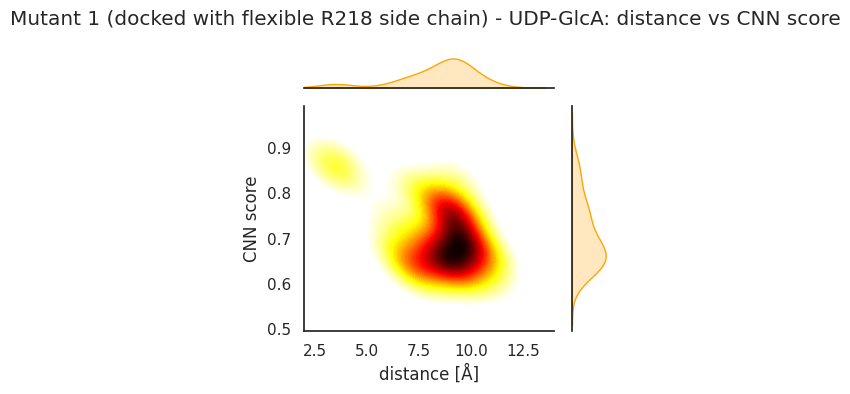

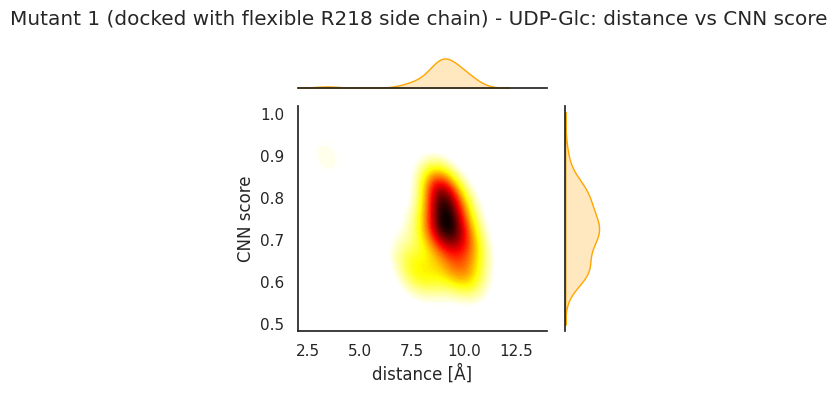

In [ ]:
sns.set(style="white")

f = sns.jointplot(x=filtered_df_glcA['distance'],
                  y=filtered_df_glcA['CNNscore'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  xlim=(2, 14),
                  height=4)
f.set_axis_labels("distance [Å]", "CNN score")
f.fig.suptitle(f'Mutant 1 (docked with flexible R218 side chain) - UDP-GlcA: distance vs CNN score')
plt.tight_layout()
plt.show()

f = sns.jointplot(x=filtered_df_glc['distance'],
                  y=filtered_df_glc['CNNscore'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  xlim=(2, 14),
                  height=4)
f.set_axis_labels("distance [Å]", "CNN score")
f.fig.suptitle(f'Mutant 1 (docked with flexible R218 side chain) - UDP-Glc: distance vs CNN score')
plt.tight_layout()
plt.show()

**Vina score vs distance**

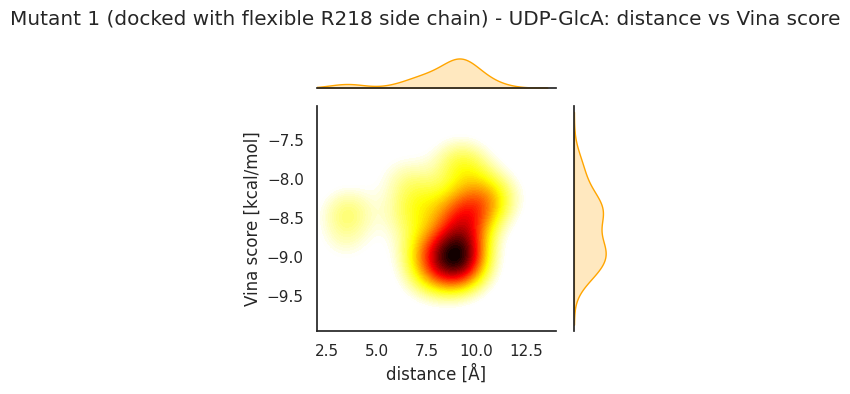

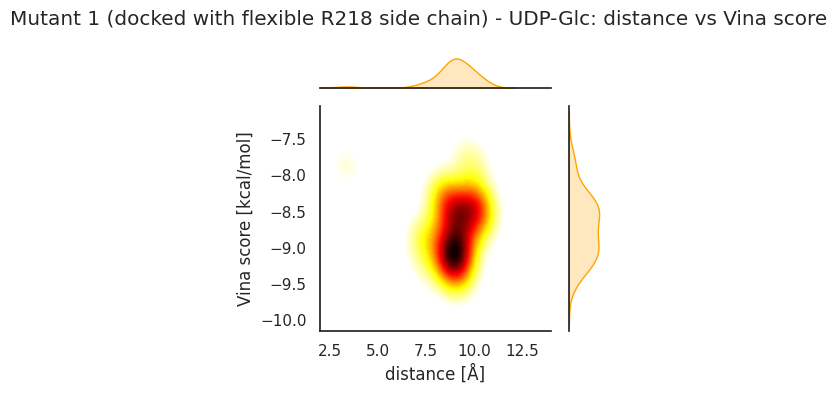

In [ ]:
sns.set(style="white")

f = sns.jointplot(x=filtered_df_glcA['distance'],
                  y=filtered_df_glcA['Vina'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  xlim=(2, 14),
                  height=4)
f.set_axis_labels("distance [Å]", "Vina score [kcal/mol]")
f.fig.suptitle(f'Mutant 1 (docked with flexible R218 side chain) - UDP-GlcA: distance vs Vina score')
plt.tight_layout()
plt.show()

f = sns.jointplot(x=filtered_df_glc['distance'],
                  y=filtered_df_glc['Vina'],
                  kind='kde',
                  cmap='hot_r',
                  n_levels=60,
                  fill=True,
                  marginal_kws=dict(color="orange"),
                  xlim=(2, 14),
                  height=4)
f.set_axis_labels("distance [Å]", "Vina score [kcal/mol]")
f.fig.suptitle(f'Mutant 1 (docked with flexible R218 side chain) - UDP-Glc: distance vs Vina score')
plt.tight_layout()
plt.show()